In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import math

sns.set_theme(rc={
    "figure.dpi": 300,
    "figure.figsize": (16, 8),
})

In [2]:
def read_input(file_path, atleast_2d=False):
    # by default a row of numbers in loaded as a 1D vector
    data = np.loadtxt(file_path)
    if atleast_2d:
        if data.ndim == 1:
            data = data.reshape((1, -1))
    return data

In [3]:
poly_path = "PA-1-data-text/polydata_data_"
X_sample = read_input(f"{poly_path}sampx.txt", atleast_2d=True)
y_sample = read_input(f"{poly_path}sampy.txt")
X_poly = read_input(f"{poly_path}polyx.txt", atleast_2d=True)
y_poly = read_input(f"{poly_path}polyy.txt")

## Part 1: Polynomial function

For this part, we first define a base class for all of the regression models. We adopt an API inspired scikit-learn, with basically 2 methods: `fit` for training the model, and `predict` for using the model.

```python
class Regression:
    def __init__(self):
        self.phi = None
        self.title = None
    
    def hyperparam(self):
        return None

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass
```

The method `hyperparam()` will be used for part 3.

In [4]:
class Regression:
    """Abstract base class for all regression models.

    Suppose a scalar function f(x, θ) with an input x ∈ R^d and an unknown parameter
    θ ∈ R^D has the form
    
        f(x, θ) = ϕ(x)^T θ,
    
    where ϕ: R^d → R^D is a known feature transformation. Given a dataset of n pairs
    (x_i, y_i) of input and *noisy* output, our goal is to estimate the value of the
    parameter θ and use it to predict the output of the function with a new input x*.
    For convenience, we define three variables

        y = [y_1 ... y_n]^T,    Φ = [ϕ(x_1) ... ϕ(x_n)],    X = [x_1 ... x_n].

    The API here mirrors that of a model in scikit-learn with two main methods:
    - `fit(X, y)`: estimate the parameter using the given data (training)
    - `predict(x)`: predict the output corresponds to the given input (inference)
    """

    def __init__(self):
        # a R^d -> R^D feature transformation
        self.phi = None
        self.title = None
    
    def hyperparam(self):
        return None

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass

### (a) Implement 5 regression algorithms

#### Least Squares Regression
This model aims to minimize the L2-norm of the difference between the given output and the output of the function, i.e.

$$
\begin{align*}
\hat\theta_{\text{LS}} = \underset{\theta}{\operatorname{arg min}} \lVert y - \Phi^T\theta \rVert^2 = (\Phi\Phi^T)^{-1}\Phi y.
\end{align*}
$$

The prediction for input $x^*$ is then $f^* = \phi(x^*)^T \hat\theta$.

In [5]:
class LS(Regression):
    """Least Squares (LS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    given output and the output of the function, i.e.

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2
             = (ΦΦ^T)^(-1)Φy

    The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """

    def __init__(self):
        self.title = f"Least Squares Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        inv = np.linalg.inv(Phi @ Phi.T)
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

#### Regularized least squares regression
This regression model aims to minimize the L2-norm of the difference between the actual and the predicted outputs plus the L2-norm of the parameter as apenalty term, i.e.,

$$
\begin{align*}
\hat\theta_{\text{RLS}} = \underset{\theta}{\operatorname{arg min}} \lVert y - \Phi^T\theta \rVert^2 + \lambda \lVert\theta\rVert^2 = (\Phi\Phi^T + \lambda I)^{-1}\Phi y.
\end{align*}
$$

Here, $\lambda$ is a hyperparameter. The prediction for input $x^*$ is then $f^* = \phi(x^*)^T \hat\theta$.

In [6]:
class RLS(Regression):
    """Regularized Least Squares (RLS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    actual and the predicted outputs, together with the L2-norm of the parameter as a
    penalty term, i.e.,

       θ^_RLS = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖^2
             = (ΦΦ^T + λI)^(-1)Φy

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """
    def __init__(self, l=None):
        self.title = f"RLS Regression (λ={l:.2f})"
        self.l = l
    
    def hyperparam(self):
        return super().hyperparam() or self.l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        inv = np.linalg.inv(Phi @ Phi.T + self.l * np.identity(D))
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

#### LASSO regression
This regression model aims to minimize the L2-norm of the difference between the actual and the predicted outputs plus the L1-norm of the parameter as apenalty term, i.e.,

$$
\begin{align*}
\hat\theta_{\text{LASSO}} = \underset{\theta}{\operatorname{arg min}} \lVert y - \Phi^T\theta \rVert^2 + \lambda \lVert\theta\rVert _1y.
\end{align*}
$$

Here, $\lambda$ is a hyperparameter. The prediction for input $x^*$ is then $f^* = \phi(x^*)^T \hat\theta$. No closed form solution exists, but we can turn the problem into a quadratic programming problem:

$$
\begin{align*}
\text{minimize } & \frac{1}{2}\mathbf{x}^T\mathbf{H}\mathbf{x} + \mathbf{f}^T x \\
\text{subject to } & \mathbf{x} \ge 0
\end{align*}
$$

where

$$
\mathbf{H} = \begin{pmatrix}
\Phi\Phi^T & -\Phi\Phi^T \\
-\Phi\Phi^T & \Phi\Phi^T
\end{pmatrix},\qquad
\mathbf{f} = \lambda \mathbf{1} - \begin{pmatrix}\Phi y\\ -\Phi y\end{pmatrix}, \qquad
\mathbf{x} = \begin{pmatrix}\theta^+\\ \theta^-\end{pmatrix},
$$
and $\theta = \theta^+-\theta^-$.

In [7]:
class LASSO(Regression):
    """LASSO Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L1-norm of the parameter as a
    penalty term, i.e.,

        θ^_LASSO = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖_1

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    This optimization problem does not have a closed form solution and requires
    quadratic programming to estimate its solution.
    """

    def __init__(self, l=None):
        self.title = f"LASSO Regression (λ={l:.2f})"
        self.l = l
    
    def hyperparam(self):
        return super().hyperparam() or self.l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        Phi_Phi_T = Phi @ Phi.T
        Phi_y = Phi @ y

        H = np.block([[Phi_Phi_T, -Phi_Phi_T], [-Phi_Phi_T, Phi_Phi_T]])
        f = self.l - np.block([Phi_y, -Phi_y])
        x = cp.Variable(2*D)

        # To avoid cases where cvxpy fails to assert H is positive semidefinite
        # due to numerical issues. See https://github.com/cvxpy/cvxpy/issues/1995
        H_psd = cp.psd_wrap(H)

        objective = cp.Minimize(cp.quad_form(x, H_psd) + 2 * f.T @ x)
        constraints = [x >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.OSQP)

        self.theta_hat = x.value[:D] - x.value[D:]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

#### Robust regression
This regression model aims to minimize the L1-norm of the difference between the actual and the predicted outputs, i.e.,

$$
\begin{align*}
\hat\theta_{\text{RR}} = \underset{\theta}{\operatorname{arg min}} \lVert y - \Phi^T\theta \rVert _1.
\end{align*}
$$

The prediction for input $x^*$ is then $f^* = \phi(x^*)^T \hat\theta$. No closed form solution exists, but we can turn the problem into a linear programming problem:

$$
\begin{align*}
\text{minimize } & \mathbf{f}^T x \\
\text{subject to } & \mathbf{Ax} \le \mathbf{b}
\end{align*}
$$

where

$$
\mathbf{f} = \begin{pmatrix}0_D\\ 1_n\end{pmatrix}, \qquad
\mathbf{A} = \begin{pmatrix}
-\Phi^T & -I \\
\Phi^T & -I
\end{pmatrix},\qquad
\mathbf{b} = \begin{pmatrix}-y \\ y\end{pmatrix},\qquad
\mathbf{x} = \begin{pmatrix}\theta \\ t\end{pmatrix},
$$
and $t$ is some parameters.

#### Robust regression
This regression model aims to minimize the L1-norm of the difference between the actual and the predicted outputs, i.e.,

$$
\begin{align*}
\hat\theta_{\text{RR}} = \underset{\theta}{\operatorname{arg min}} \lVert y - \Phi^T\theta \rVert _1.
\end{align*}
$$

The prediction for input $x^*$ is then $f^* = \phi(x^*)^T \hat\theta$. No closed form solution exists, but we can turn the problem into a linear programming problem:

$$
\begin{align*}
\text{minimize } & \frac{1}{2}x^T\mathbf{H}x + \mathbf{f}^T x \\
\text{subject to } & x \ge 0
\end{align*}
$$

where

$$
\mathbf{H} = \begin{pmatrix}
\Phi\Phi^T & -\Phi\Phi^T \\
-\Phi\Phi^T & \Phi\Phi^T
\end{pmatrix},\qquad
\mathbf{f} = \lambda \mathbf{1} - \begin{pmatrix}\Phi y\\ -\Phi y\end{pmatrix}.
$$

In [8]:
class RR(Regression):
    """Robust Regression

    This regression model aims to minimize the L1-norm of the difference between the
    real and the predicted outputs, i.e.,

        θ^_RR = argmin_θ ‖y - Φ^T θ‖_1

    The prediction for input x* is then f* = ϕ(x*)^T θ^. This optimization problem does
    not have a closed form solution and requires linear programming to estimate its
    solution.
    """

    def __init__(self):
        self.title = f"Robust Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D, n = Phi.shape

        A = np.block([[-Phi.T, -np.identity(n)], [Phi.T, -np.identity(n)]])
        f = np.block([np.zeros(D), np.ones(n)])
        b = np.block([-y, y])
        x = cp.Variable(D+n)

        objective = cp.Minimize(f @ x)
        constraints = [A @ x <= b]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

#### Bayesian regression
This model aims to update its prior beliefs about the parameter using the given data to produce the posterior distribution of the parameter. Suppose $\theta$ has multivariate i.i.d. Gaussian prior distribution $\theta\sim ~ \mathcal{N}(0, \alpha I)$ and the observed outputs have Gaussian noises with constant variance added to the "true" output, i.e., the sampling distribution is $y\mid x,\theta \sim \mathcal{N}(f(x,\theta), \sigma^2)$. Then, the posterior is

$$
\begin{align*}
\theta\mid X,y &\sim \mathcal{N}(\hat\mu_\theta, \hat\Sigma_\theta^2), \\
\hat\mu_\theta &= \sigma^{-2} \hat\Sigma_\theta \Phi y, \\
\hat\Sigma_\theta &= (\alpha^{-1}I + \sigma^{-2}\Phi\Phi^T)^{-1}.
\end{align*}
$$

The predictive distribution for input $x^*$ is a Gaussian, with

$$
\begin{align*}
f^*\mid X,y,x^* &\sim \mathcal{N}(\mu^*, \sigma_*^2), \\
\mu^* &= \phi(x^*)^T \hat\mu_\theta, \\
\sigma_*^2 &= \phi(x^*)^T \hat\Sigma_\theta \phi(x^*)
\end{align*}
$$

In [9]:
class BR(Regression):
    """Bayesian Regression

    This regression model aims to update its prior beliefs about the parameter using
    the given data to produce the posterior distribution of the parameter. Suppose θ
    has multivariate i.i.d. Gaussian prior distribution θ ~ N(0, αI) and the observed
    outputs have Gaussian noises with constant variance added to the "true" output,
    i.e., the sampling distribution is y|x,θ ~ N(f(x,θ), σ^2). Then, the posterior is

        θ|X,y ~ N(μ^_θ, Σ^_θ^2)
        μ^_θ = σ^(-2) Σ^_θ Φy
        Σ^_θ = (α^(-1)I + σ^(-2)ΦΦ^T)^(-1)

    The predictive distribution for input x* is a Gaussian, with

        f*|X,y,x* ~ N(μ^*, σ^*^2)
        μ^* = ϕ(x*)^T μ^_θ
        σ^*^2 = ϕ(x*)^T Σ^_θ ϕ(x*)
    """

    def __init__(self, alpha=None, sigma_2=None):
        self.title = f"Bayesian Regression (α={alpha:.1f}, σ²={sigma_2:.1f})"
        self.alpha = alpha
        self.sigma_2 = sigma_2
    
    def hyperparam(self):
        return super().hyperparam() or (self.alpha, self.sigma_2)

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        Phi_Phi_T = Phi @ Phi.T
        D = Phi.shape[0]

        self.Sigma_hat_theta = np.linalg.inv(np.identity(D) / self.alpha + Phi_Phi_T / self.sigma_2)
        self.mu_hat_theta = self.Sigma_hat_theta @ Phi @ y / self.sigma_2
        return self.mu_hat_theta

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        mu_hat = (Phi.T @ self.mu_hat_theta).reshape((-1,))
        sigma_2_hat = np.diag(Phi.T @ self.Sigma_hat_theta @ Phi)
        return (mu_hat, sigma_2_hat)

### (b) Fit, predict, and plot

We now use the models with the given data. Our pipeline is basically:
1. Set the feature transformation of each model to be a quintic polynomial.
2. Fit the model using the training data.
3. Predict the values from the testing data.
4. Calculate metrics such as MSE, MAE, and $R^2$ score.
5. Plot the resulting predictions

In [10]:
poly_5 = lambda x: x[0]**np.array(range(6))

In [11]:
def fit_predict_1b(model, phi, X_train, y_train, X_test, y_test):
    model.phi = phi
    result = model.fit(X_train, y_train)
    y_test_predict, std = model.predict(X_test)

    mae = np.abs(y_test - y_test_predict).mean()
    mse = np.square(y_test - y_test_predict).mean()

    R2 = 1 - np.sum((y_test - y_test_predict)**2) / np.sum((y_test - np.mean(y_test))**2)

    return (result, y_test_predict, std, mae, mse, R2)

Least Squares Regression
MAE=0.5207,    MSE=0.4086,    R²=0.9943
----------------------------------------
RLS Regression (λ=0.10)
MAE=0.5202,    MSE=0.4082,    R²=0.9943
----------------------------------------
LASSO Regression (λ=0.20)
MAE=0.5246,    MSE=0.4191,    R²=0.9941
----------------------------------------
Robust Regression
MAE=0.6612,    MSE=0.7680,    R²=0.9892
----------------------------------------


Bayesian Regression (α=1.0, σ²=0.4)
MAE=0.5189,    MSE=0.4076,    R²=0.9943
----------------------------------------


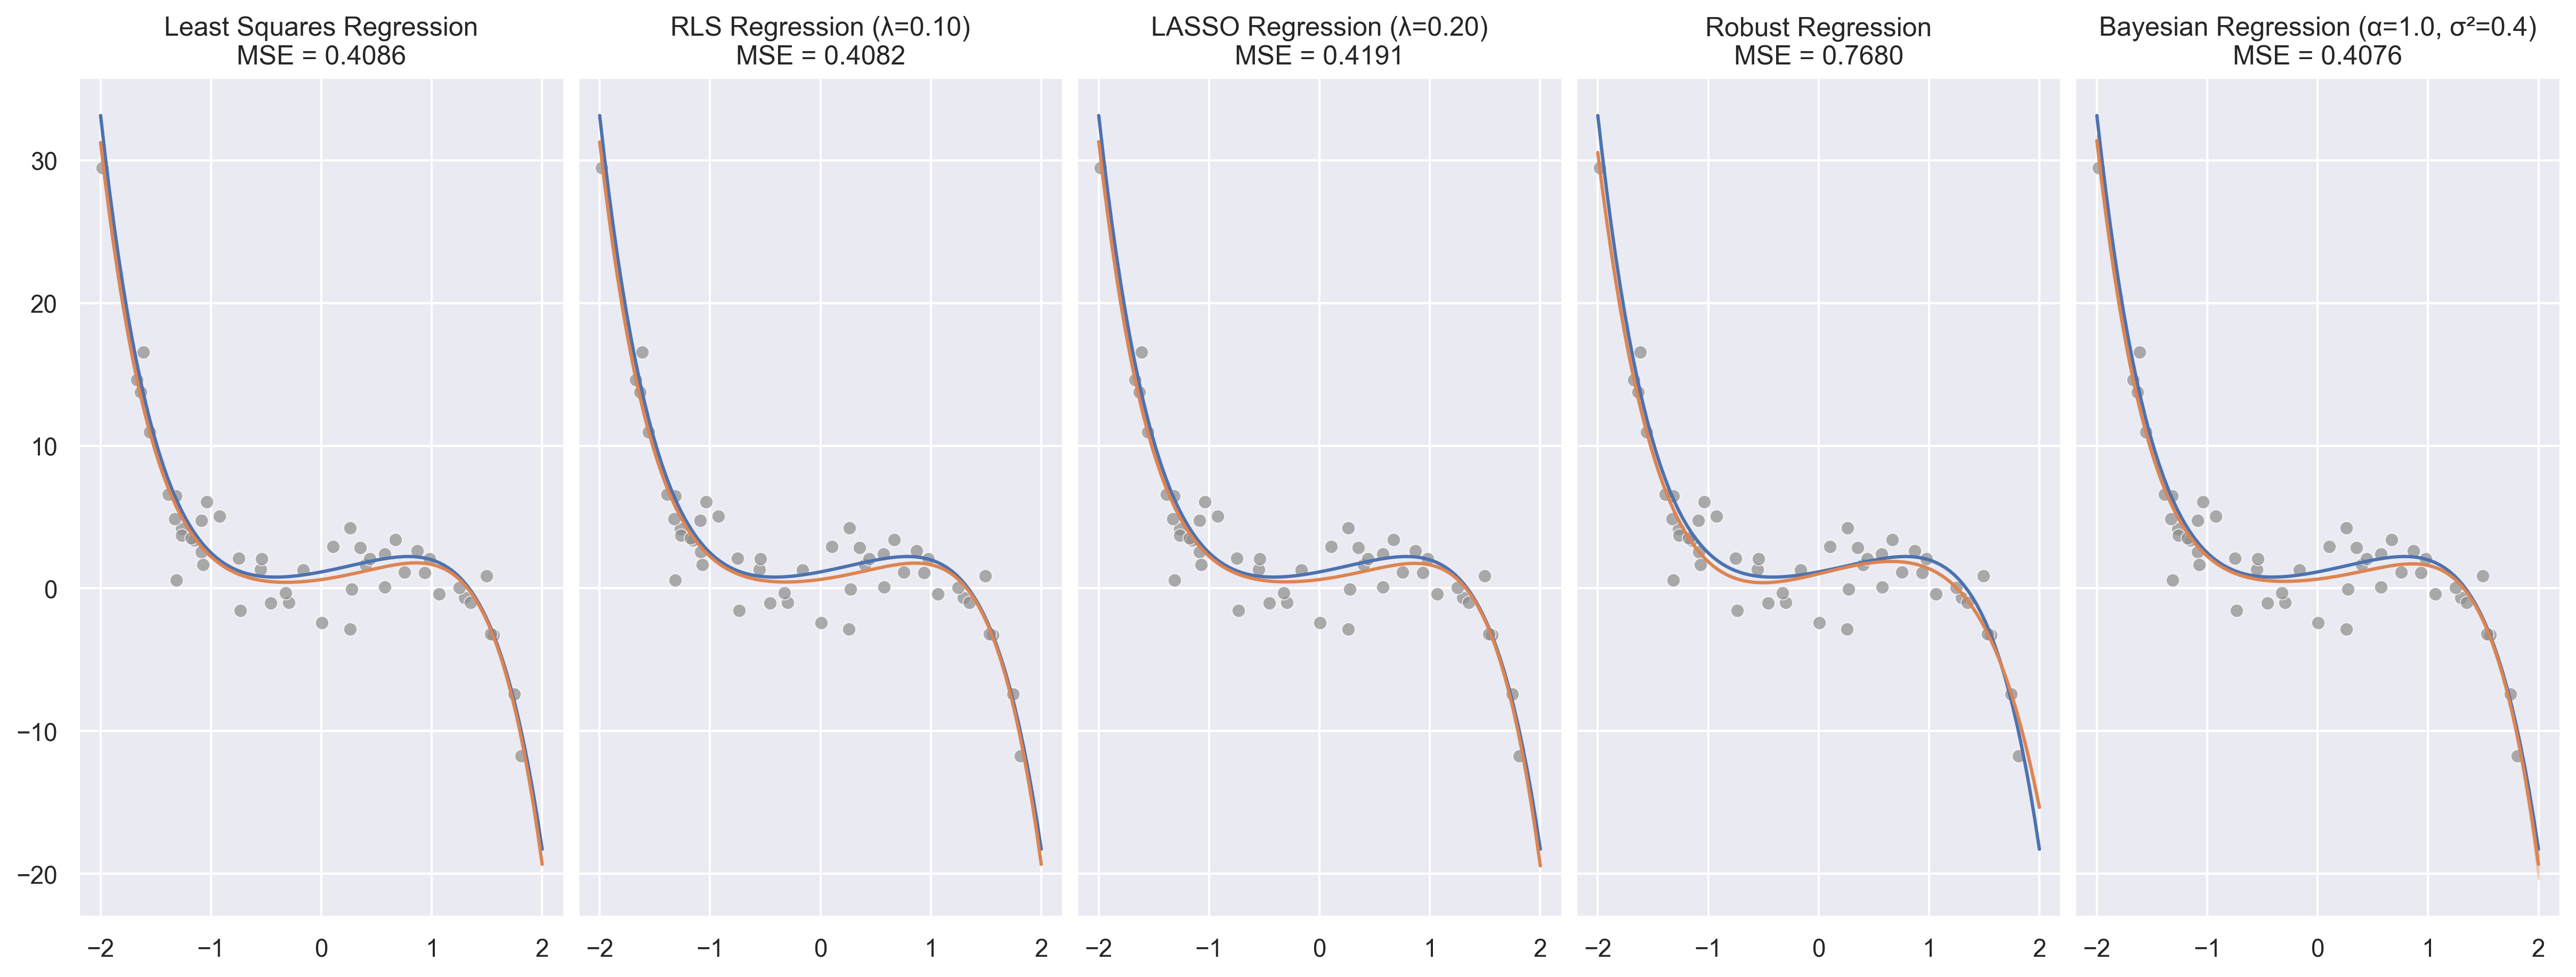

In [12]:
def fit_predict_plot(models, phi):
    fig, axs = plt.subplots(1, len(models), figsize=(16, 6), sharey=True, constrained_layout=True)
    for model, ax in zip(models, axs):
        result, y_poly_predict, std, mae, mse, R2 = fit_predict_1b(model, phi, X_sample, y_sample, X_poly, y_poly)

        print(model.title)
        print(f"MAE={mae:.4f},    MSE={mse:.4f},    R²={R2:.4f}")
        print("-" * 40)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)
        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1b = [LS(), RLS(l=0.1), LASSO(l=0.2), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot(models_1b, phi=poly_5)

### (c) Smaller training data

Least Squares Regression
MAE=4.0868,    MSE=34.0653,    R²=0.5209
----------------------------------------
RLS Regression (λ=1.00)
MAE=1.3426,    MSE=2.3660,    R²=0.9667
----------------------------------------
LASSO Regression (λ=1.00)
MAE=1.0958,    MSE=1.6170,    R²=0.9773
----------------------------------------
Robust Regression
MAE=5.3458,    MSE=58.3056,    R²=0.1799
----------------------------------------
Bayesian Regression (α=0.3, σ²=1.5)
MAE=1.4424,    MSE=2.7599,    R²=0.9612
----------------------------------------


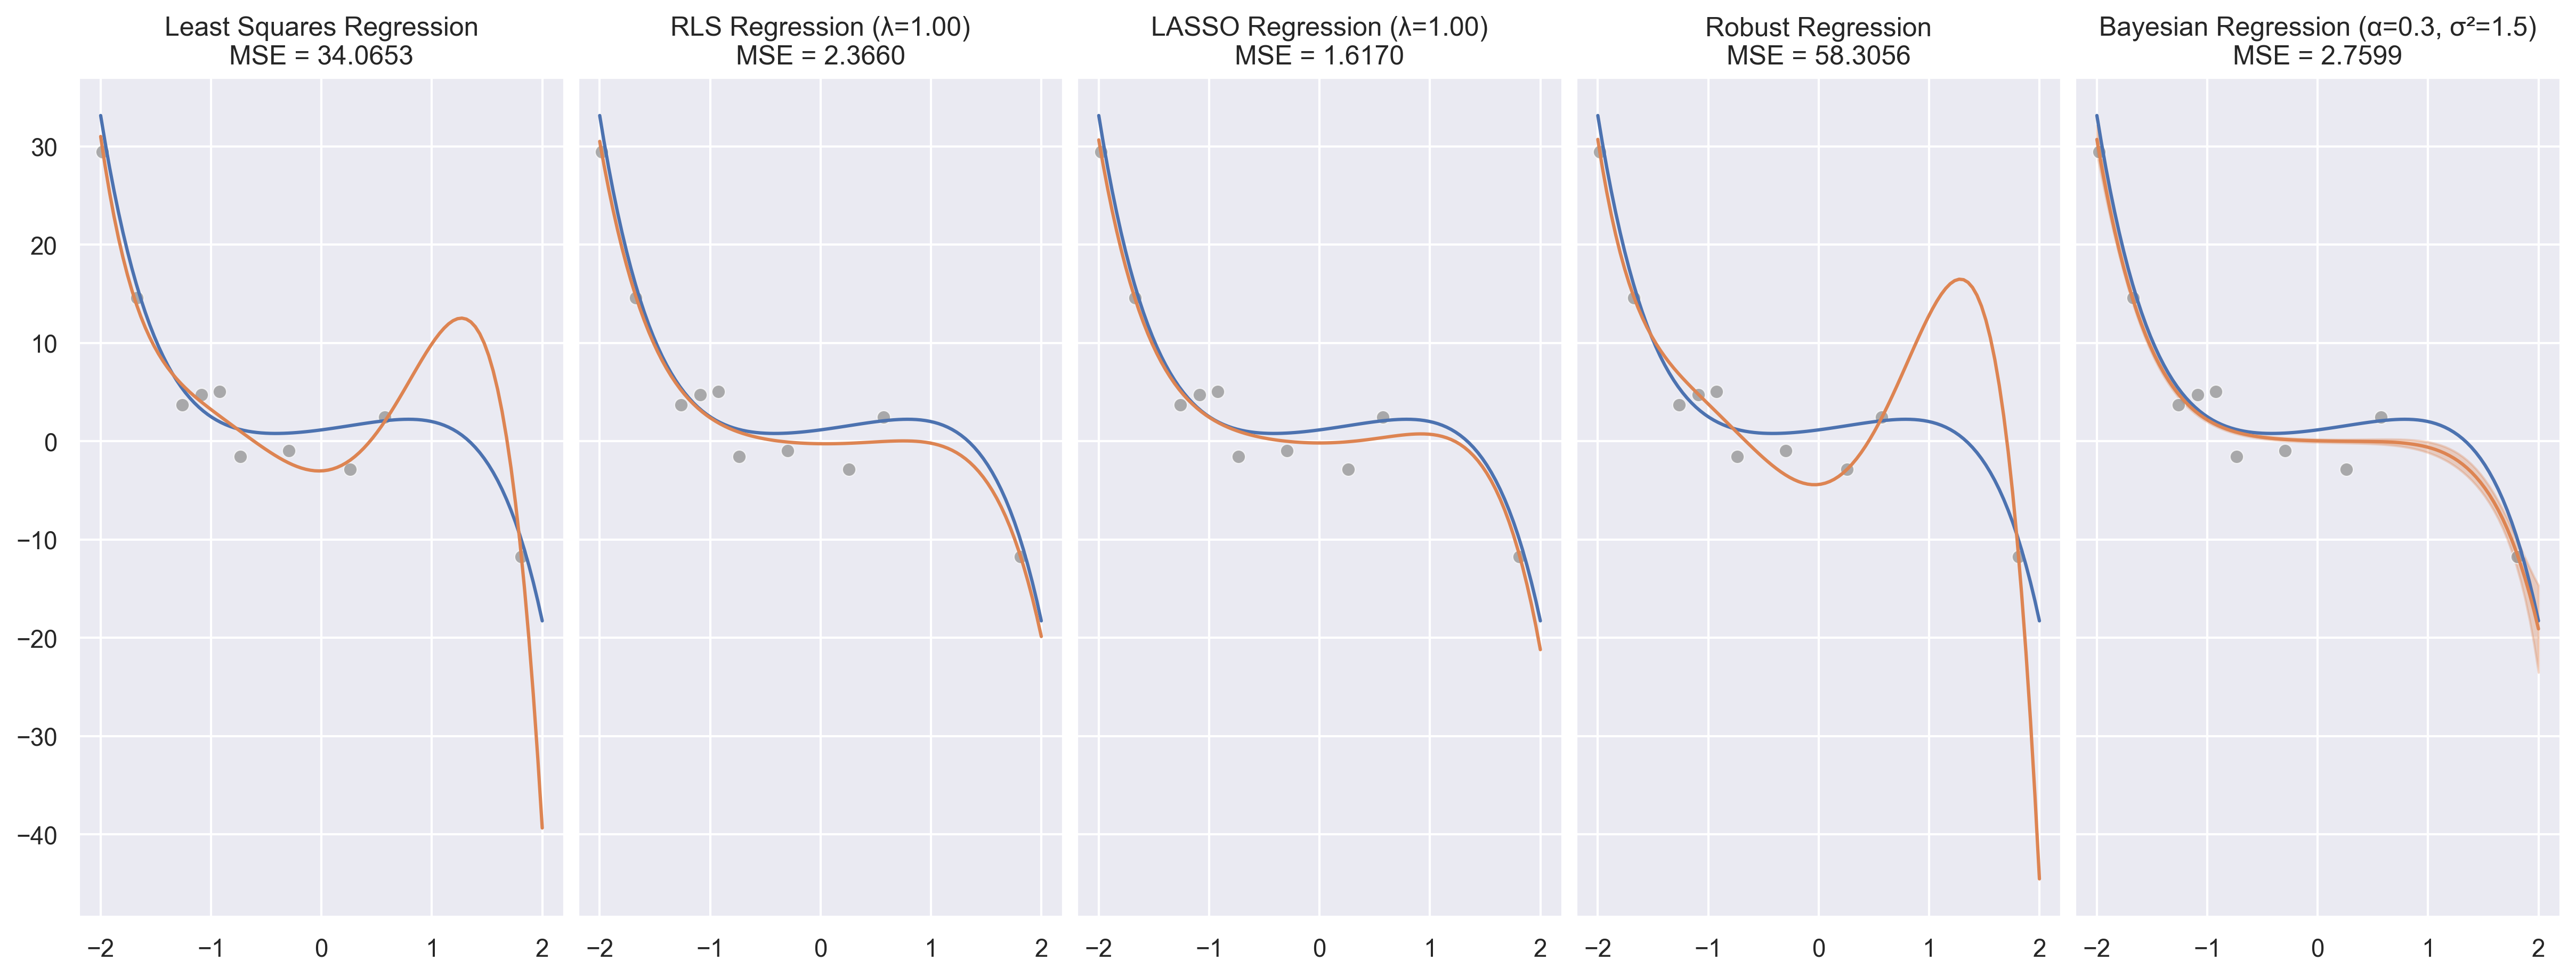

In [13]:
def fit_predict_plot_reduced_data(models, phi=poly_5, training_size=1, seed=12):
    n = y_sample.size
    rng = np.random.default_rng(seed)
    rand_idx = rng.permutation(n)[:math.ceil(n * training_size)]
    X_sample_subset = X_sample[:, rand_idx]
    y_sample_subset = y_sample[rand_idx]

    fig, axs = plt.subplots(1, len(models), sharey=True, figsize=(16, 6), constrained_layout=True)

    for model, ax in zip(models, axs):
        result, y_poly_predict, std, mae, mse, R2 = fit_predict_1b(model, phi, X_sample_subset, y_sample_subset, X_poly, y_poly)

        print(model.title)
        print(f"MAE={mae:.4f},    MSE={mse:.4f},    R²={R2:.4f}")
        print("-" * 40)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_subset.reshape((-1,)), y=y_sample_subset, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1c = [LS(), RLS(l=1), LASSO(l=1), RR(), BR(alpha=0.3, sigma_2=1.5)]
fit_predict_plot_reduced_data(models_1c, training_size=0.2, seed=123)

Above is a the same plot from 1(b) but with a reduced subset of training data, specifically 20% of the original dataset. Already, we can see signs of overfitting from least squares and robust regression, a fact that will be explored more in the next part.

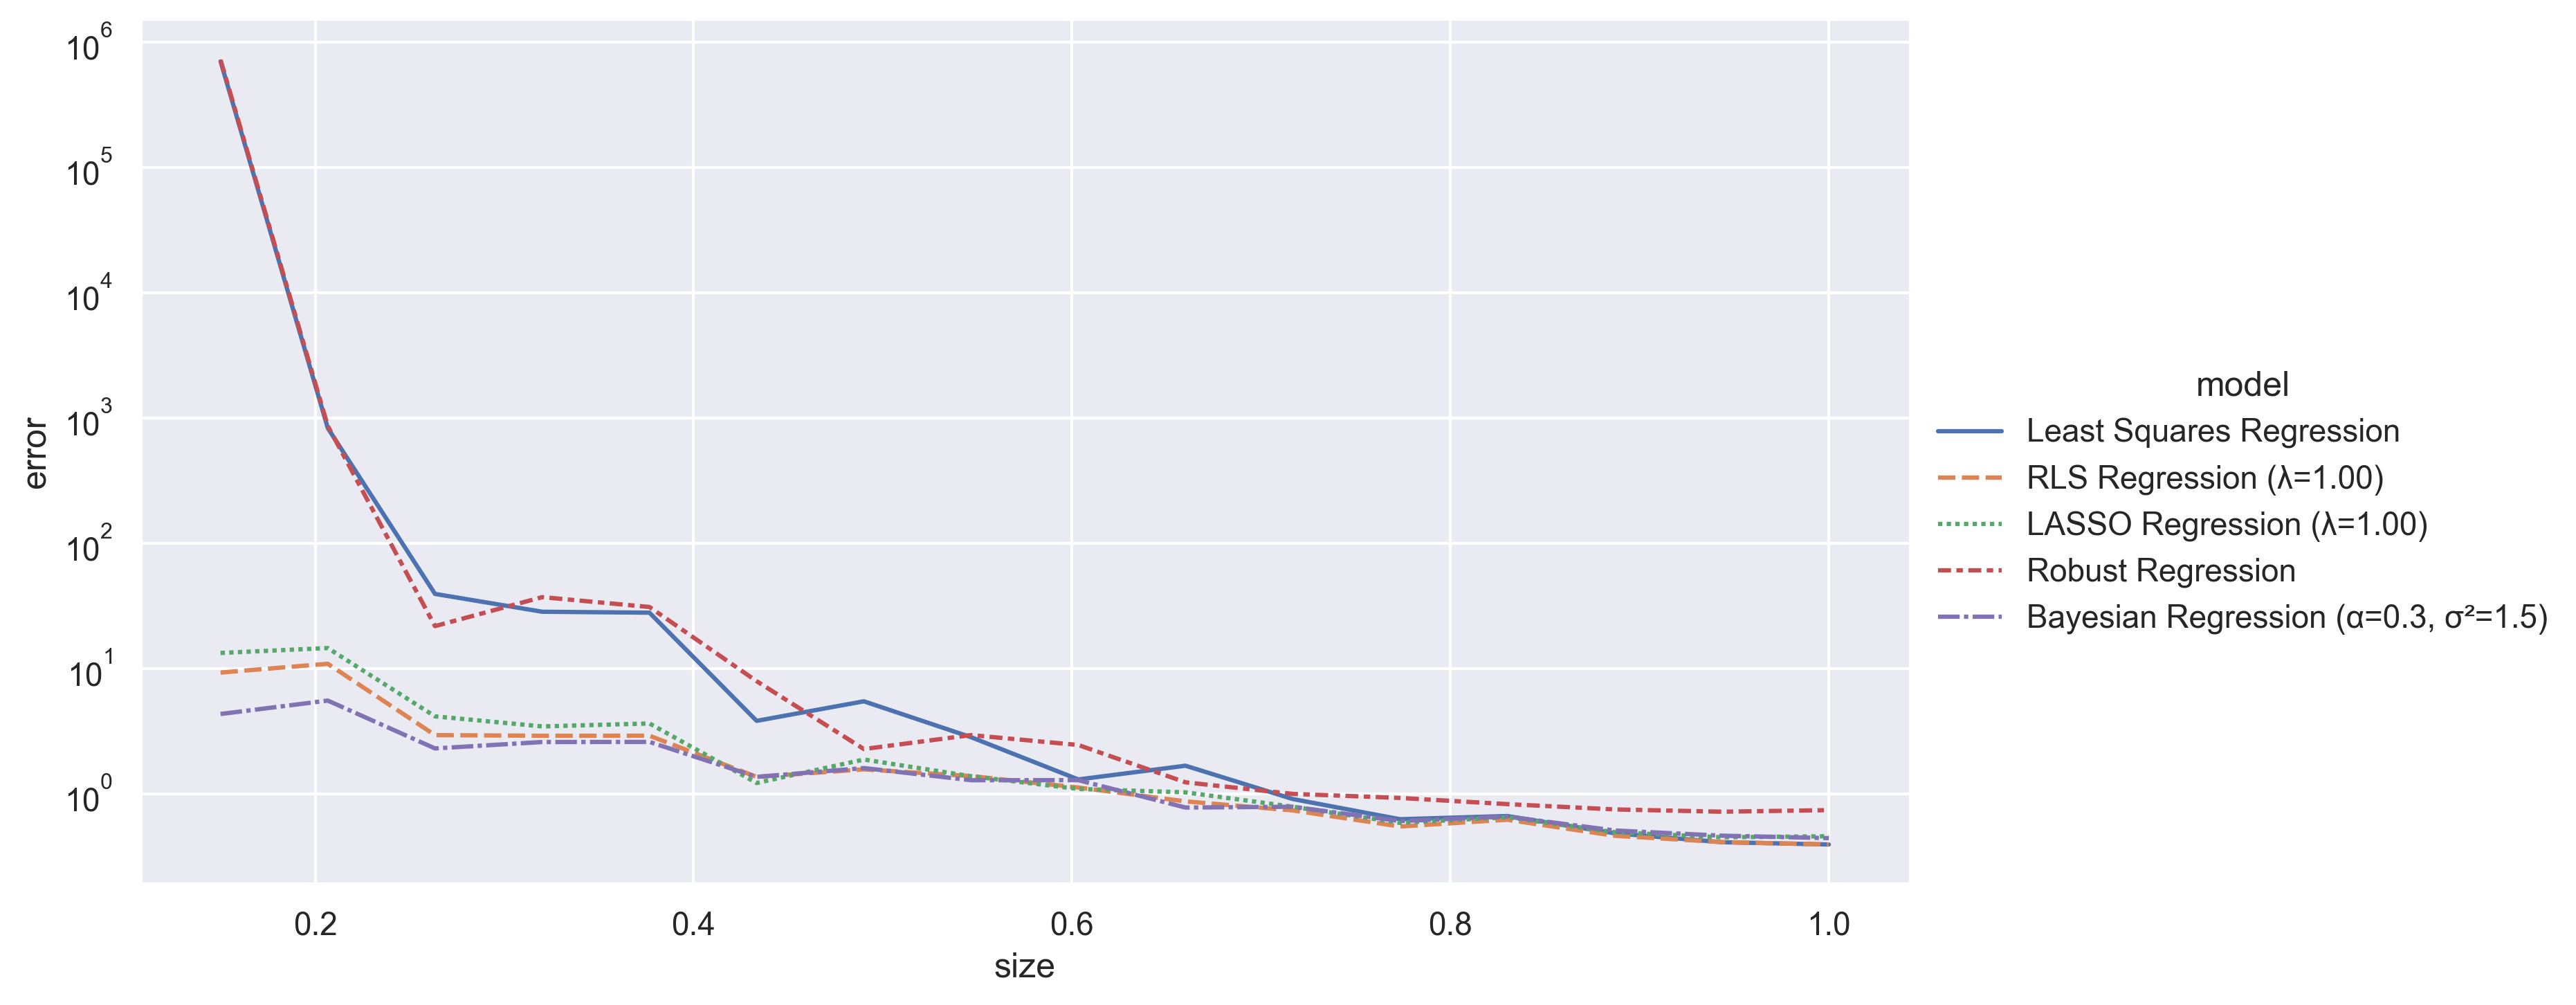

In [14]:
def error_vs_training_size(models, phi=poly_5, num_sizes=10, num_samples=5, seed=12):
    n = y_sample.size
    sizes = np.linspace(0.15, 1, num=num_sizes)
    rng = np.random.default_rng(seed)
    seeds = rng.integers(10*num_sizes*num_samples, size=(num_sizes, num_samples))

    def sample_mses(models, subset_size, seed):
        rng = np.random.default_rng(seed)
        rand_idx = rng.permutation(n)[:subset_size]
        X_sample_subset = X_sample[:, rand_idx]
        y_sample_subset = y_sample[rand_idx]

        mses = []
        for model in models:
            *_, mse, R2 = fit_predict_1b(model, phi, X_sample_subset, y_sample_subset, X_poly, y_poly)

            mses.append(mse)
        return mses

    # row 1: size, row 2: errors, row 3: model
    data = np.empty((3, 0))
    for i, size in np.ndenumerate(sizes):
        subset_size = int(n * size) + 1
        # average MSE of each model at training_size=size based on multiple samples
        errors = np.zeros((1, len(models)))
        for run in range(num_samples):
            mses = sample_mses(models, subset_size, seeds[i[0], run])
            errors = np.vstack((errors, mses))
        mean_mses = errors.mean(axis=0)
        sample_result = np.vstack((
            np.full_like(mean_mses, size),
            mean_mses,
            np.arange(len(models)),
        ))
        data = np.hstack((data, sample_result))

    titles = np.array([model.title for model in models])
    df = pd.DataFrame({
        "size": data[0, :],
        "error": data[1, :],
        "model": titles[data[2, :].astype(int)],
    })

    g = sns.relplot(
        data=df,
        x="size",
        y="error",
        hue="model",
        style="model",
        kind="line",
        aspect=2,
    )
    g.set(yscale="log")

error_vs_training_size(models_1c, num_sizes=16, num_samples=30, seed=123)

In the above experiment, for each specific training subset size, e.g., 0.5, we select a random subset of the training data of that size then fit the regression models to it for 50 times, then take the average mean squared error (MSE). In the end, we get a plot like above, where `size` indicates the proportion of the selected training data, and `error` is the average MSE of each model after repeat 50 times. Note that the $y$-axis is in log scale, as with few data points, least squares and robust regression tends to overfit heavily, and the quintic polynomial feature transform exaggerates the difference even more (see the previous plot).

We see that when the amount of data is very low, i.e., around 30% smaller than the original training set, the best performing model is undoubtedly Bayesian regression, followed by RLS and LASSO regression, while least squares and robust regression performs very badly due to overfitting. When there are a decent amount of data, then all methods except robust regression perform equally well, with robust regression falling behind when the subset approaches the full original training data. Overall, the most robust method seems to be Bayesian regression.

### (d) Outliers robustness

Next, we use the full dataset but add a few outliers to the training data. Here is a plot of the model performance with 3 outliers.

Least Squares Regression
MAE=3.2278,    MSE=16.1863,    R²=0.7723
----------------------------------------
RLS Regression (λ=100.00)
MAE=1.3407,    MSE=3.8415,    R²=0.9460
----------------------------------------
LASSO Regression (λ=100.00)
MAE=1.2052,    MSE=3.3872,    R²=0.9524
----------------------------------------
Robust Regression
MAE=0.6333,    MSE=0.7916,    R²=0.9889
----------------------------------------
Bayesian Regression (α=0.3, σ²=10.0)
MAE=1.5137,    MSE=4.6440,    R²=0.9347
----------------------------------------


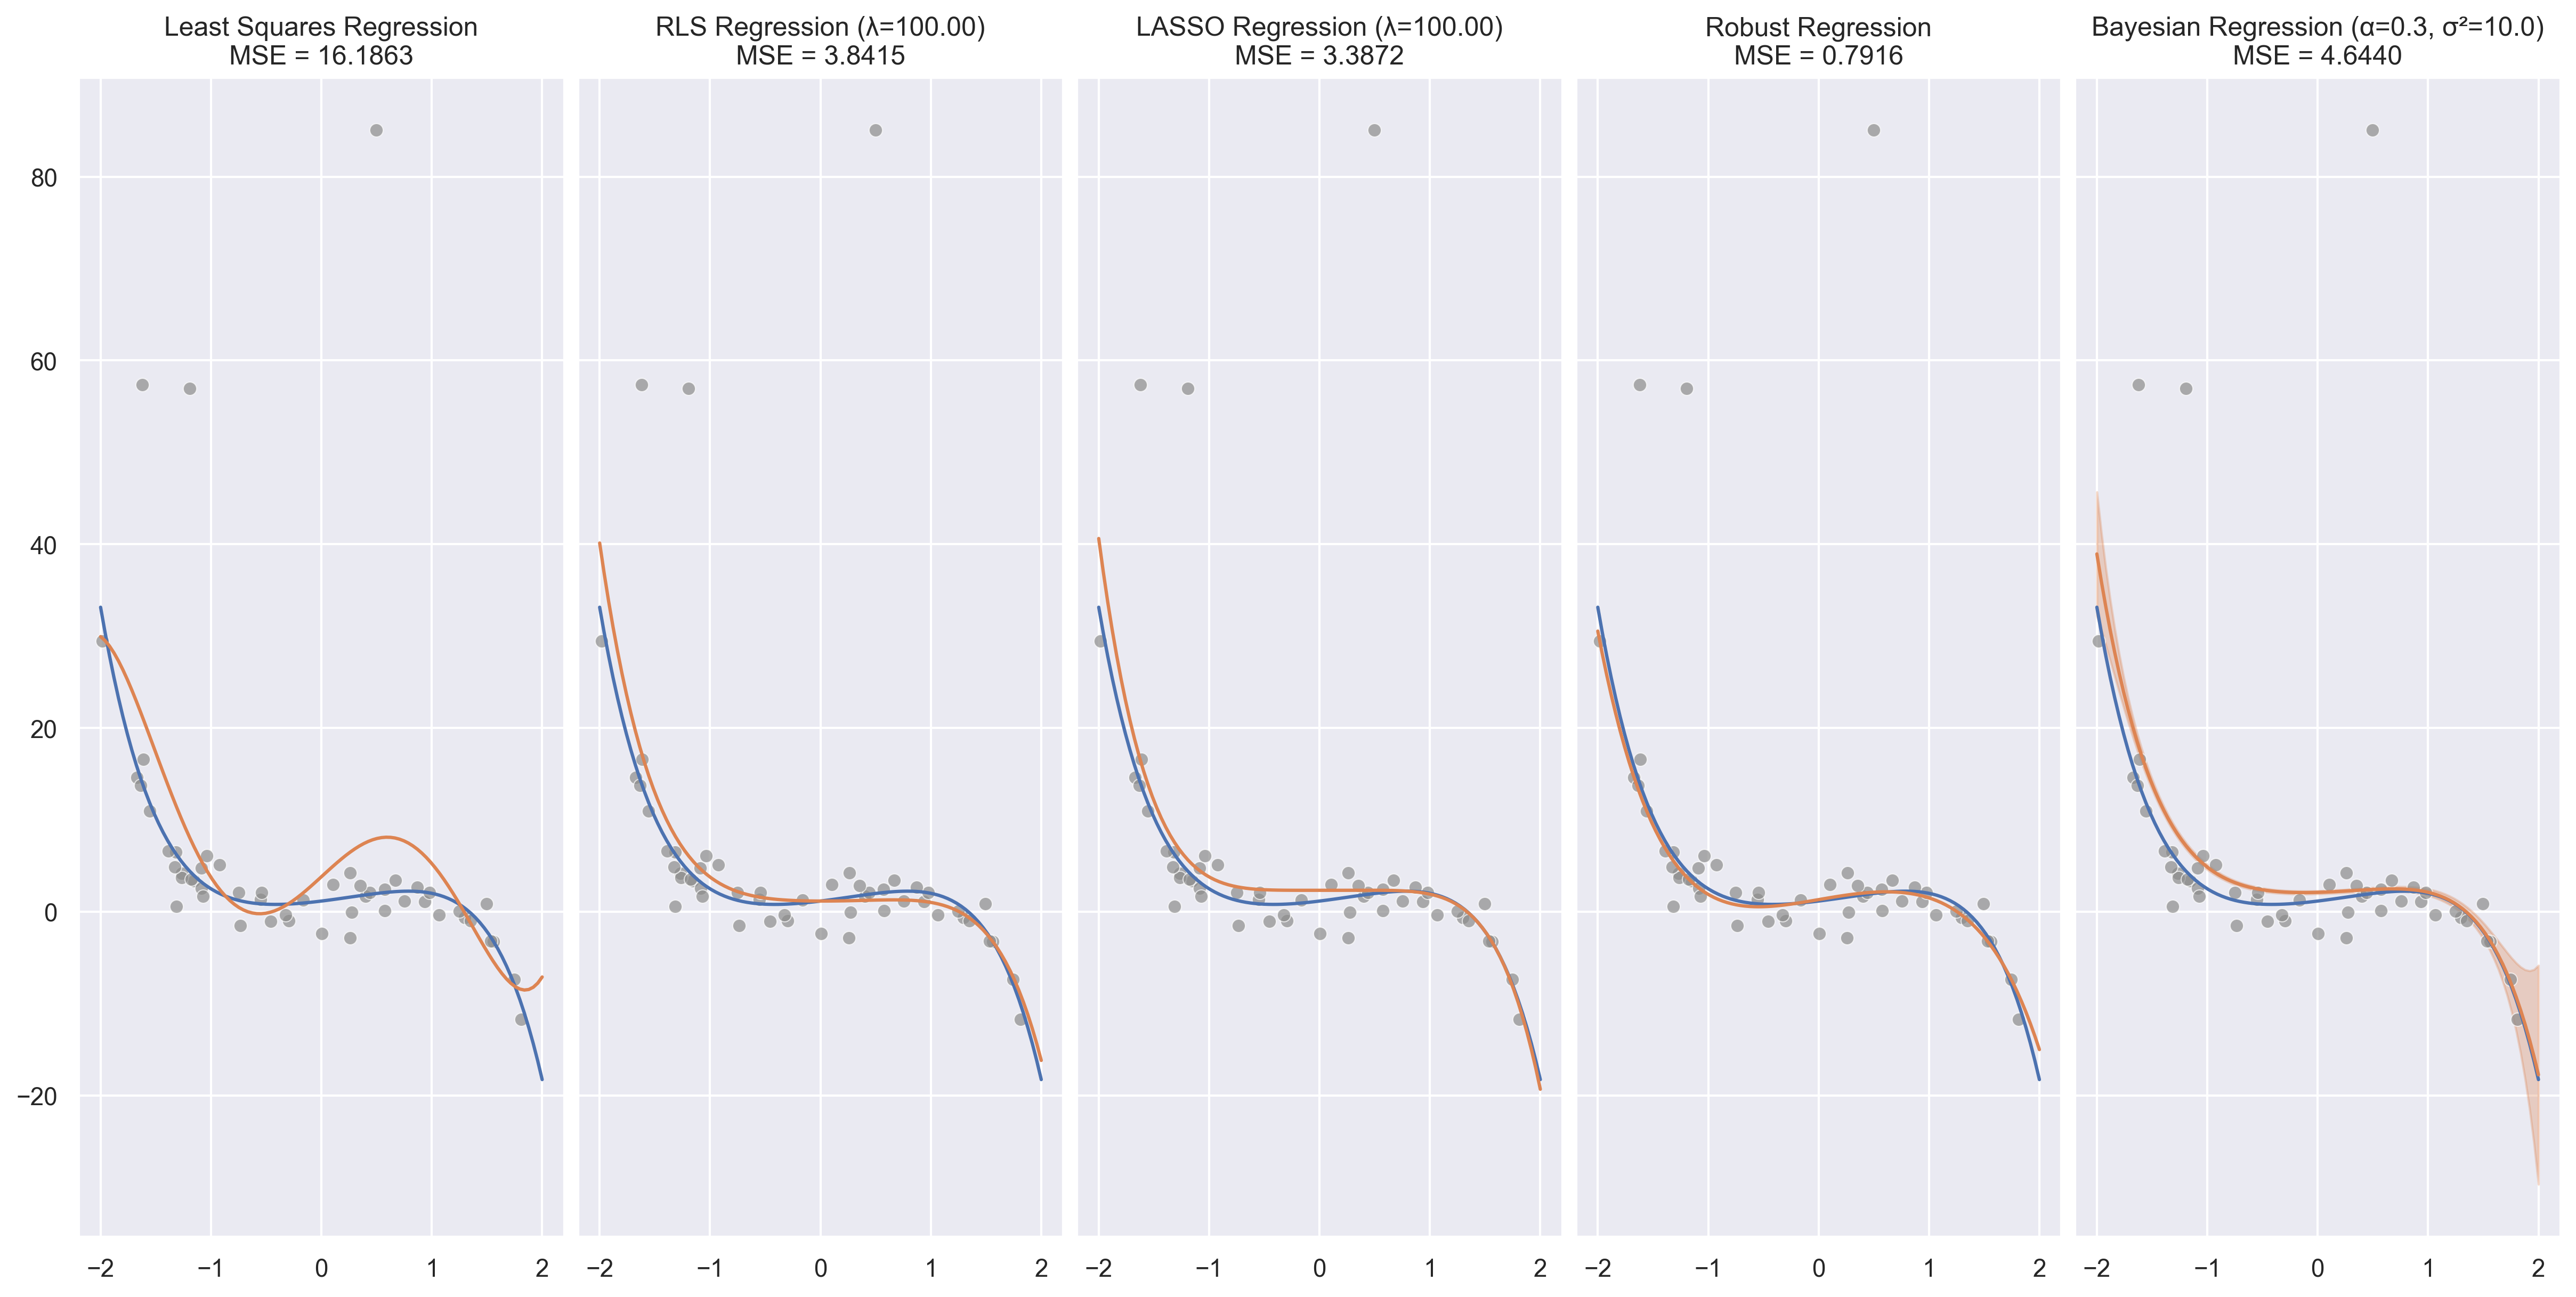

In [15]:
def fit_predict_plot_outliers(models, phi=poly_5, num_outliers=3, seed=12):
    rng = np.random.default_rng(seed)
    upper = abs(np.max(y_sample))
    qs = np.sort(rng.random(size=num_outliers))

    X_outlier = np.quantile(X_sample, qs, axis=1).T
    y_outlier = rng.uniform(low=1.5*upper+5, high=3*upper + 5, size=num_outliers)
    X_sample_outlier = np.hstack((X_sample, X_outlier))
    y_sample_outlier = np.hstack((y_sample, y_outlier))

    fig, axs = plt.subplots(1, len(models), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        result, y_poly_predict, std, mae, mse, R2 = fit_predict_1b(model, phi, X_sample_outlier, y_sample_outlier, X_poly, y_poly)

        print(model.title)
        print(f"MAE={mae:.4f},    MSE={mse:.4f},    R²={R2:.4f}")
        print("-" * 40)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_outlier.reshape((-1,)), y=y_sample_outlier, alpha=0.7, color=colors[7], ax=ax)
        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1d = [LS(), RLS(l=100), LASSO(l=100), RR(), BR(alpha=0.3, sigma_2=10)]
fit_predict_plot_outliers(models_1d, num_outliers=3, seed=123)

In the presence of outliers, robust regression is the best method, with outliers bearing virtually no negative impact on its accuracy and precision. In my opinion, this is because robust regression optimizes the $L^1$-norm of the error, which is less sensitive to outliers compared to the standard $L^2$-norm (alternatively, the statistics that minimizes the $L^1$-norm is the median, which is less affected by the tail of the distribution). RLS, LASSO, and Bayesian regression are also somewhat capable of handling the case of outliers by tweaking their hyperparameters, specifically by
- choosing a large lambda to penalize the complexity of the estimator in the case of RLS and LASSO, and
- choosing a large sample variance to signify a higher possibility of outliers in the case of Bayesian regression.

Here, least squares regression performs the worst and is easily affected by outliers, even with just one of them, due to it optimizing the $L_2$-norm, which overemphasizes outliers by squaring them, and inability to regulate its behavior through the use of penalty terms or prior beliefs.

### (e) Complex model

We now use the original dataset but swap the feature transform to a polynomial of degree 10.

Least Squares Regression
[ -0.09937581   3.79351203   6.49122012 -10.74477383  -5.52167701
   8.63226351   0.6537136   -3.04579888   0.76354946   0.31028117
  -0.17513791]
------------------------------------------------------------------------
RLS Regression (λ=3.00)
[ 0.84208891  0.32357596  0.78369772 -0.40735401 -0.0073885  -0.29183431
 -0.29336061 -0.14217197  0.34445196 -0.00102968 -0.07224856]
------------------------------------------------------------------------
LASSO Regression (λ=0.50)
[ 5.20181208e-01  9.99149184e-01  2.65111278e+00 -1.52834537e+00
 -8.53522556e-01 -1.67747585e-05 -1.29899149e+00  7.02514621e-03
  1.05514836e+00 -5.05913705e-02 -1.85751166e-01]
------------------------------------------------------------------------
Robust Regression
[ -0.77214121   3.0252024   13.14885338  -7.57592575 -19.78002561
   5.64238377  12.19446275  -2.16419757  -3.15723807   0.24538581
   0.29052235]
------------------------------------------------------------------------
Bayesi

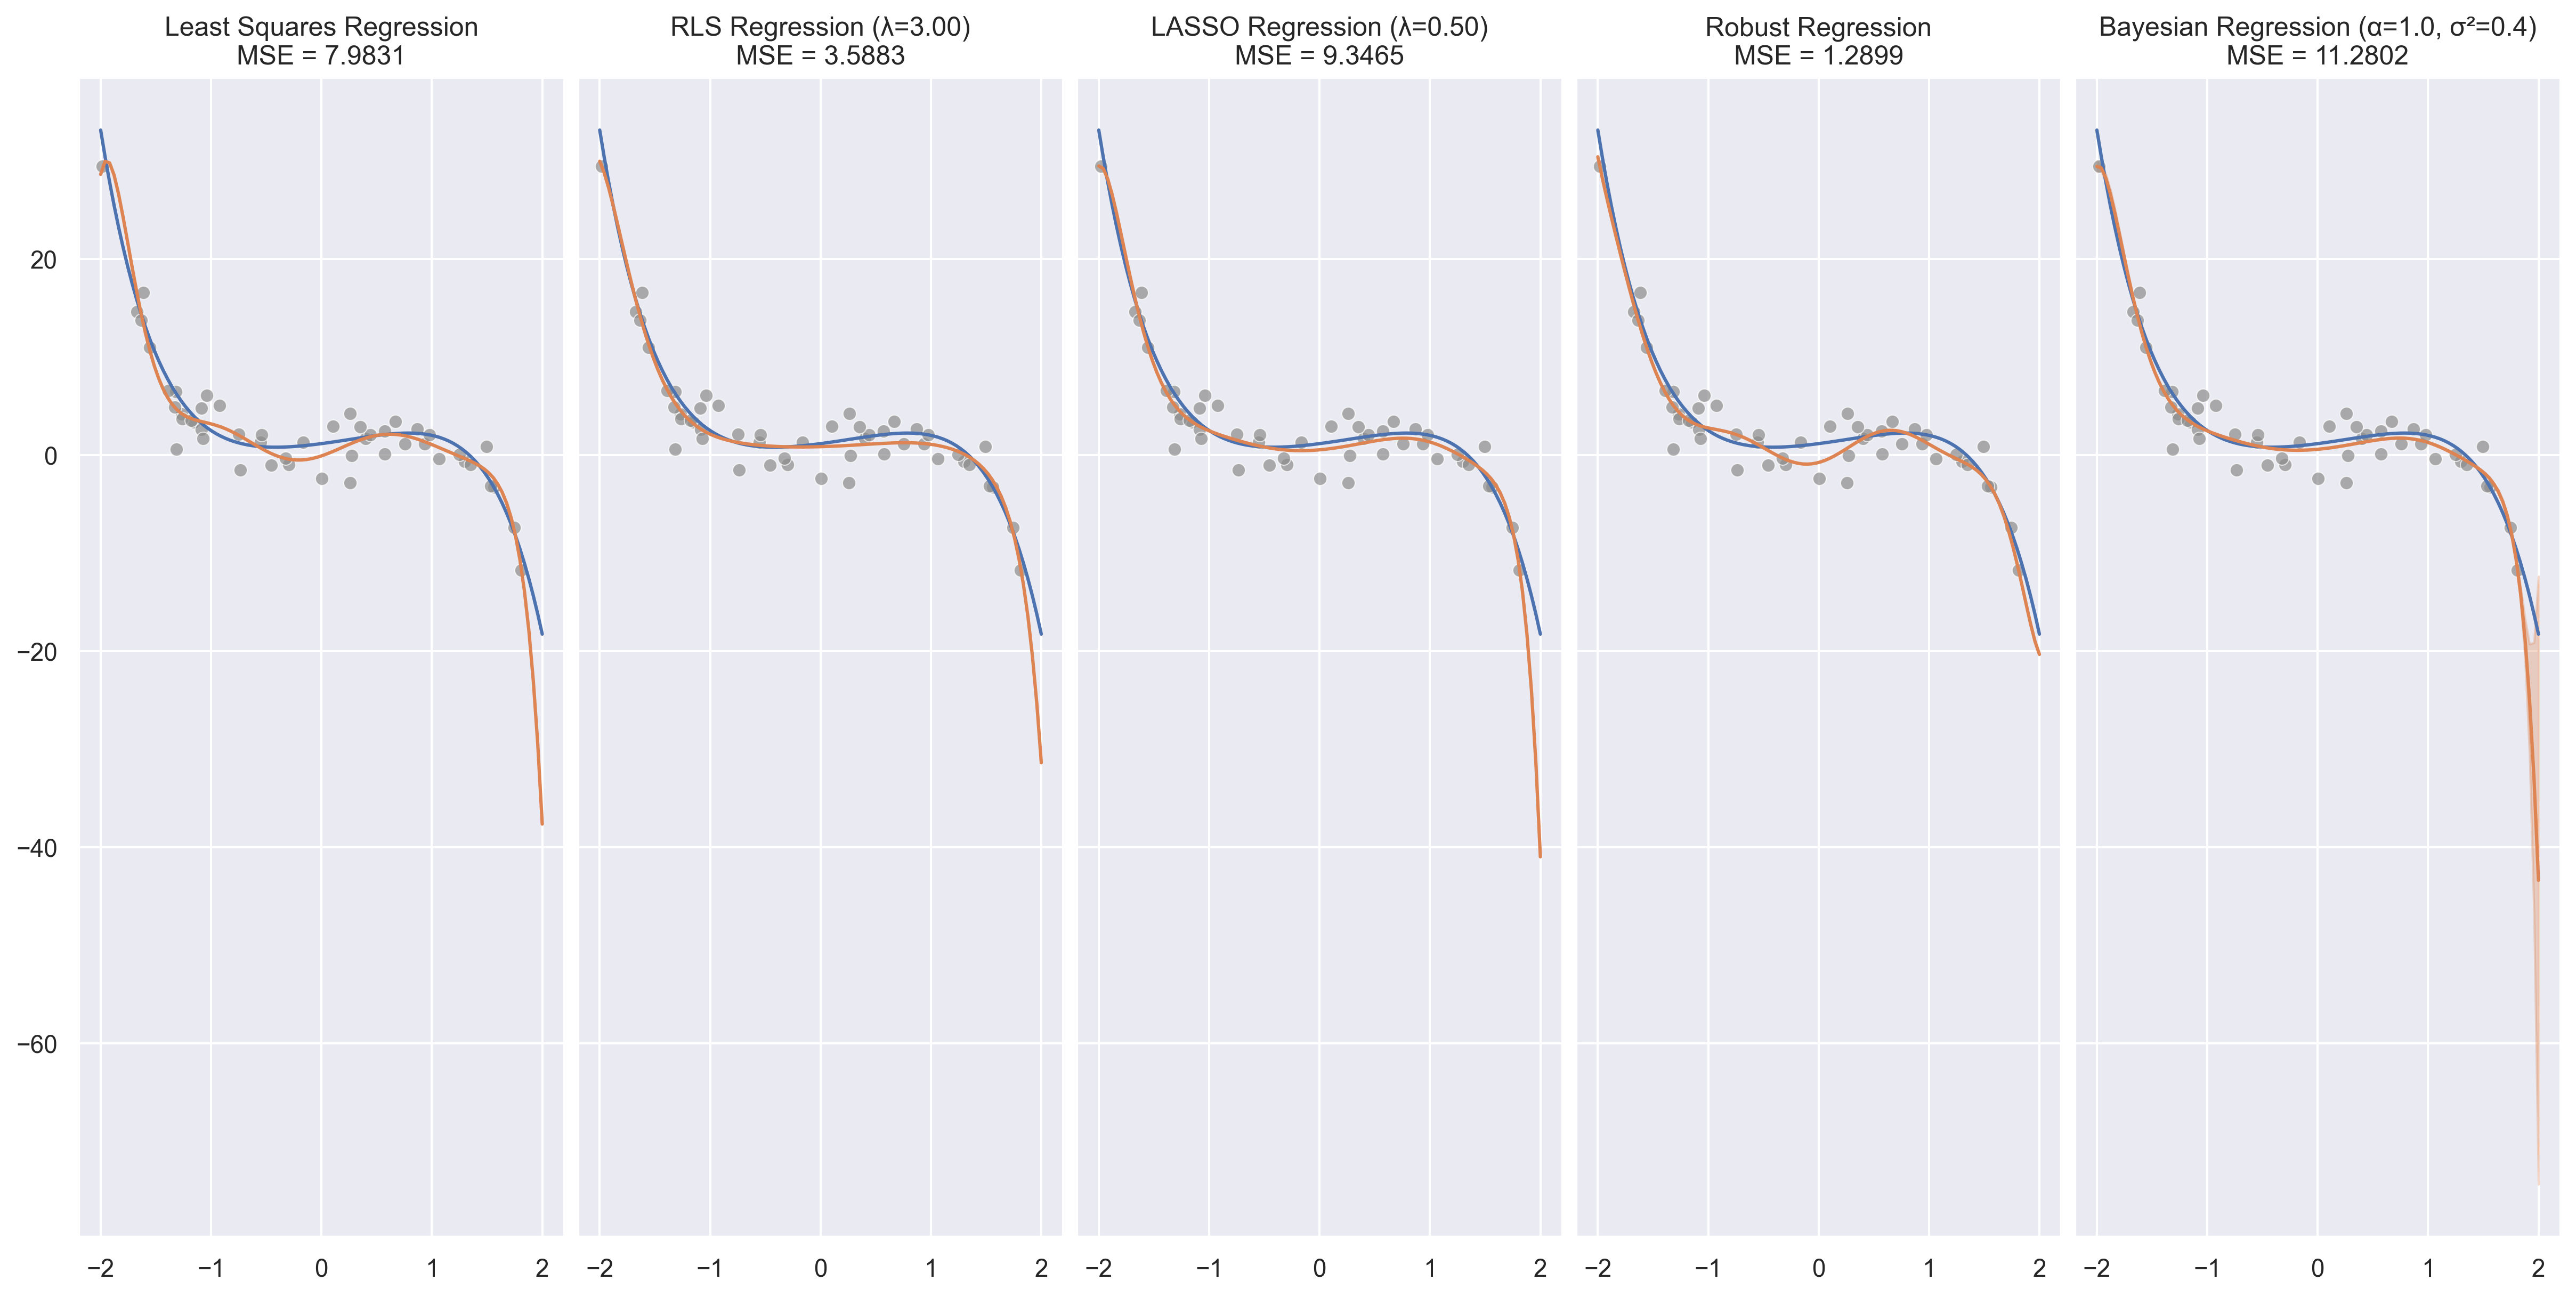

In [16]:
def fit_predict_plot_poly_10(models):
    poly_10 = lambda x: x[0]**np.array(range(10+1))

    fig, axs = plt.subplots(1, len(models), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        result, y_poly_predict, std, mae, mse, R2 = fit_predict_1b(model, poly_10, X_sample, y_sample, X_poly, y_poly)

        print(model.title)
        print(result)
        print("-" * 72)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)
        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1e = [LS(), RLS(l=3), LASSO(l=0.5), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot_poly_10(models_1e)

From the graph, we can see that least squares and robust regression exhibit the highest degree of overfitting a complex model to the data, with their prediction curved strangely to the training data. Bayesian regression also suffers somewhat from this problem, while LASSO and RLS regression are the most resistant to overfitting. Examining the estimated parameters corroborates our belief: RLS, LASSO, and Bayesian regression parameters are mostly in the normal range of $[-2,2]$, while the parameters predicted by least squares and robust regression have much larger magnitudes (exceeding 5 or even 10), a sign of overfitting in play.

## Part 2: Counting people

In [17]:
count_path = "PA-1-data-text/count_data_"
y_mean_2 = read_input(f"{count_path}ym.txt")
X_train_2 = read_input(f"{count_path}trainx.txt", atleast_2d=True)
y_train_2 = read_input(f"{count_path}trainy.txt")
X_test_2 = read_input(f"{count_path}testx.txt", atleast_2d=True)
y_test_2 = read_input(f"{count_path}testy.txt")

We can first try to plot the training data to see if there is visible relationship. Since we have 9 features, it is difficult to comprehensively visualize the datatset in one single plot, so we will plot each feature against the people count. Here, we can say roughly that the dependent $y$ is most strongly positively correlated with $x_0$ and $x_1$, slightly less so with $x_5$ and $x_6$, while being negatively correlated with $x_8$.

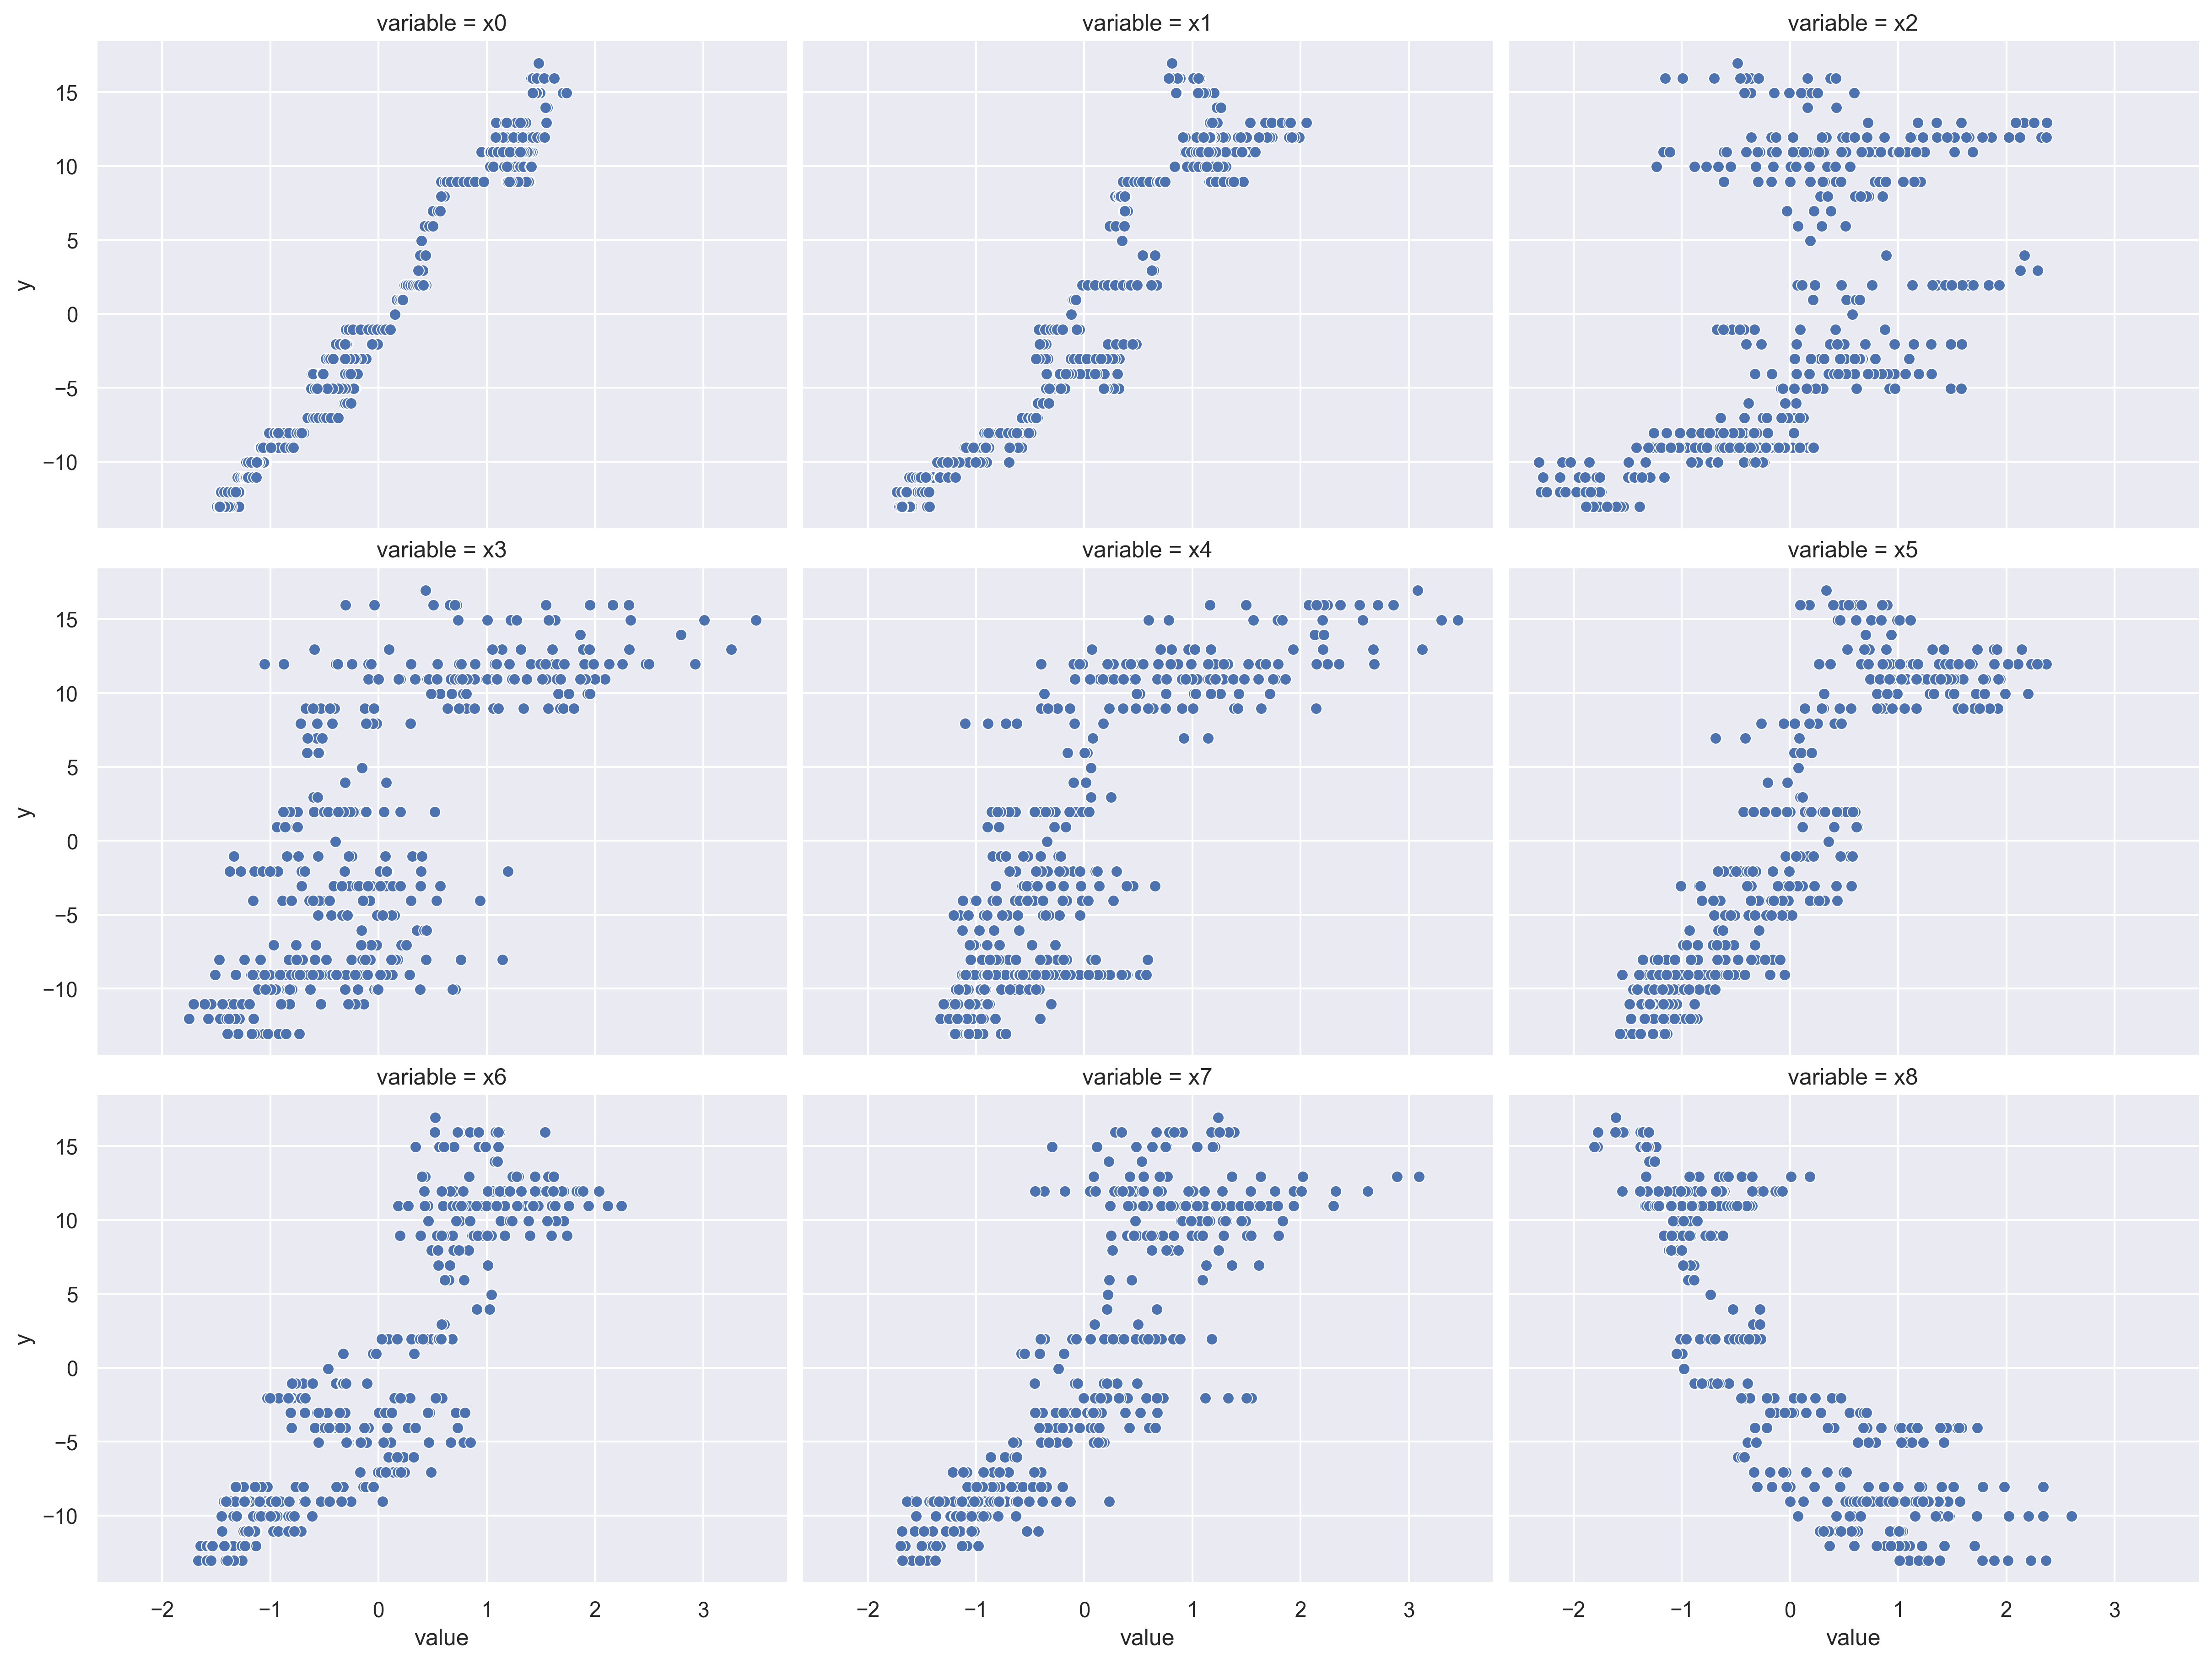

In [18]:
def plot_features_2():
    df_Xy = pd.DataFrame(np.column_stack((X_train_2.T, y_train_2)), columns=[f"x{i}" for i in range(9)] + ["y"])
    df_Xy = df_Xy.melt(id_vars=["y"])
    g = sns.relplot(df_Xy, x="value", y="y", col="variable", col_wrap=3, aspect=1.5)
    g.figure.set_layout_engine("constrained")
    g.figure.set_size_inches(16, 12)

plot_features_2()

### 2(a) Regression for counting

We simply apply the model from the previous part to this part, adapted with rounding to get the final predictions. Here, all models use the identity $x\mapsto x$ as the feature transformation.

Least Squares Regression
MAE=1.3250,    MSE=3.1450,    R²=0.9542
----------------------------------------
RLS Regression (λ=0.50)
MAE=1.2617,    MSE=2.7417,    R²=0.9600
----------------------------------------
LASSO Regression (λ=5.00)
MAE=1.2233,    MSE=2.4900,    R²=0.9637
----------------------------------------
Robust Regression
MAE=1.3350,    MSE=3.1783,    R²=0.9537
----------------------------------------
Bayesian Regression (α=1.5, σ²=1.2)
MAE=1.2600,    MSE=2.7133,    R²=0.9604
----------------------------------------


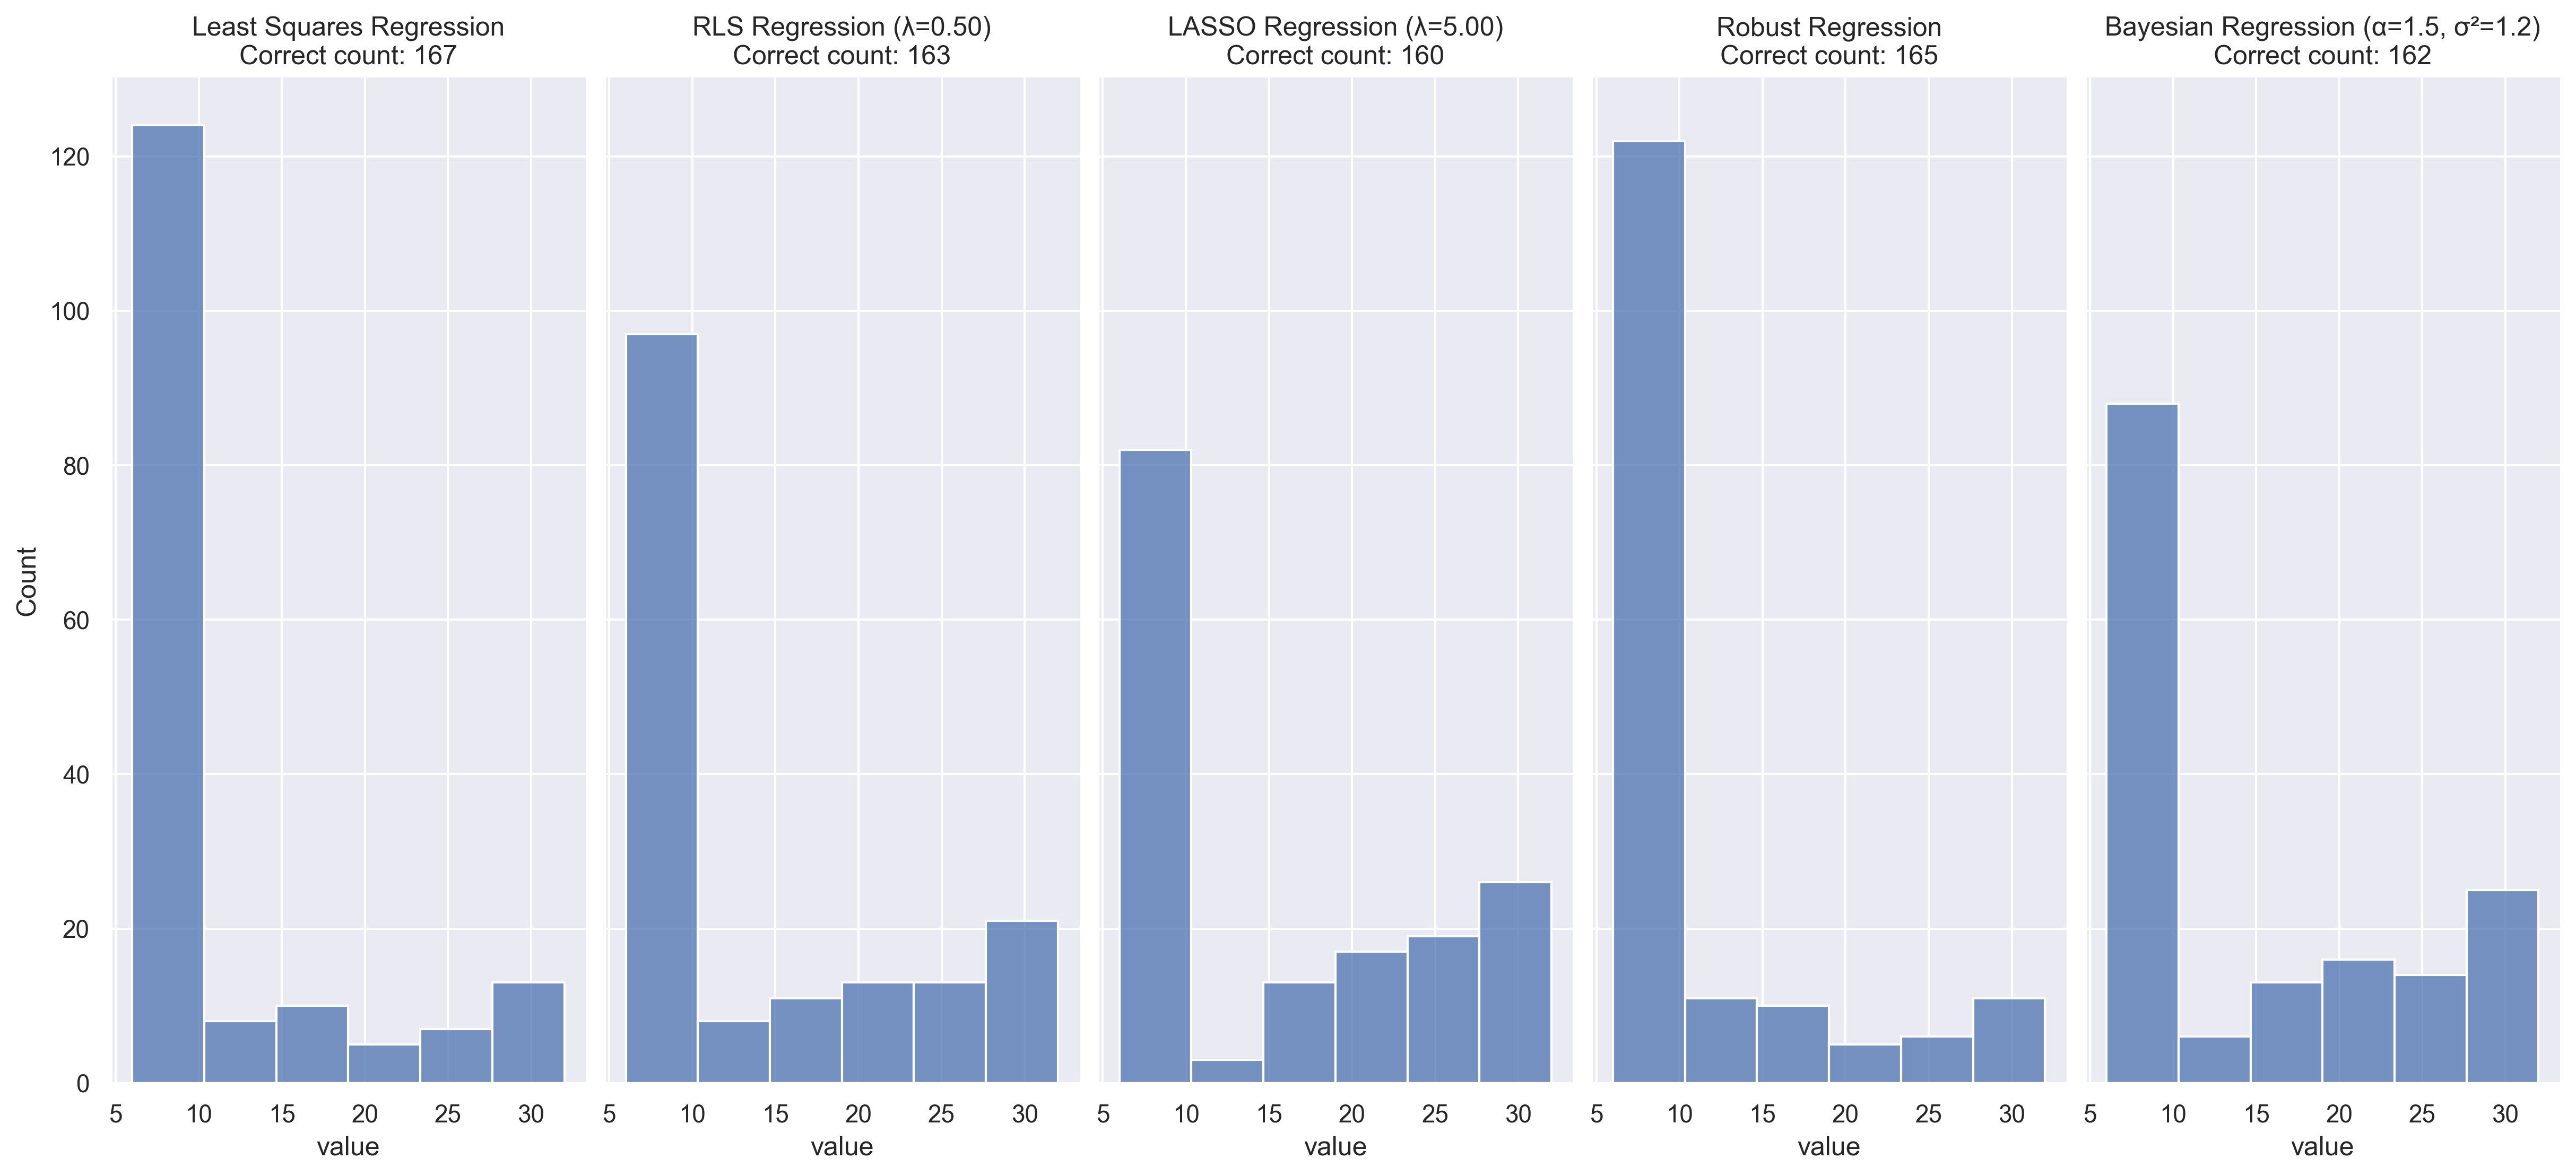

In [19]:
def fit_predict_2a(model, phi, X_train, y_train, X_test, y_test):
    model.phi = phi
    result = model.fit(X_train, y_train)
    y_test_predict, std = model.predict(X_test)

    y_test_int = y_test + y_mean_2
    y_test_predict_int = np.round(y_test_predict + y_mean_2)

    mae = np.abs(y_test_int - y_test_predict_int).mean()
    mse = np.square(y_test_int - y_test_predict_int).mean()
    correct_predicts = y_test_int[y_test_int == y_test_predict_int]

    R2 = 1 - np.sum((y_test_int - y_test_predict_int)**2) / np.sum((y_test_int - y_mean_2)**2)

    return (mae, mse, correct_predicts, R2)

def fit_predict_plot_2a(models, phi):
    df = pd.DataFrame()
    correct_counts = []
    for model in models:
        mae, mse, correct_predicts, R2 = fit_predict_2a(model, phi, X_train_2, y_train_2, X_test_2, y_test_2)

        print(model.title)
        print(f"MAE={mae:.4f},    MSE={mse:.4f},    R²={R2:.4f}")
        print("-" * 40)

        correct_counts.append(correct_predicts.size)
        df_correct_predict = pd.DataFrame({
            "value": correct_predicts,
            "model": [model.title] * correct_predicts.size,
        })
        df = pd.concat([df, df_correct_predict], axis=0)

    g = sns.displot(df, x="value", binwidth=4, col="model")
    g.figure.set_size_inches(16, 8)
    for ax, model, count in zip(g.axes[0], models, correct_counts):
        ax.set_title(f"{model.title}\nCorrect count: {count}")

models_2a = [LS(), RLS(l=0.5), LASSO(l=5), RR(), BR(alpha=1.5, sigma_2=1.2)]
fit_predict_plot_2a(models_2a, phi=lambda x: x)

### 2(b) Alternative feature transformation

Least Squares Regression
MAE=1.3083,    MSE=3.0017,    R²=0.9562
----------------------------------------
RLS Regression (λ=0.50)
MAE=1.1767,    MSE=2.4500,    R²=0.9643
----------------------------------------
LASSO Regression (λ=5.00)
MAE=1.1383,    MSE=2.4183,    R²=0.9647
----------------------------------------
Robust Regression
MAE=1.3000,    MSE=3.0133,    R²=0.9561
----------------------------------------
Bayesian Regression (α=1.5, σ²=1.2)
MAE=1.1833,    MSE=2.5233,    R²=0.9632
----------------------------------------


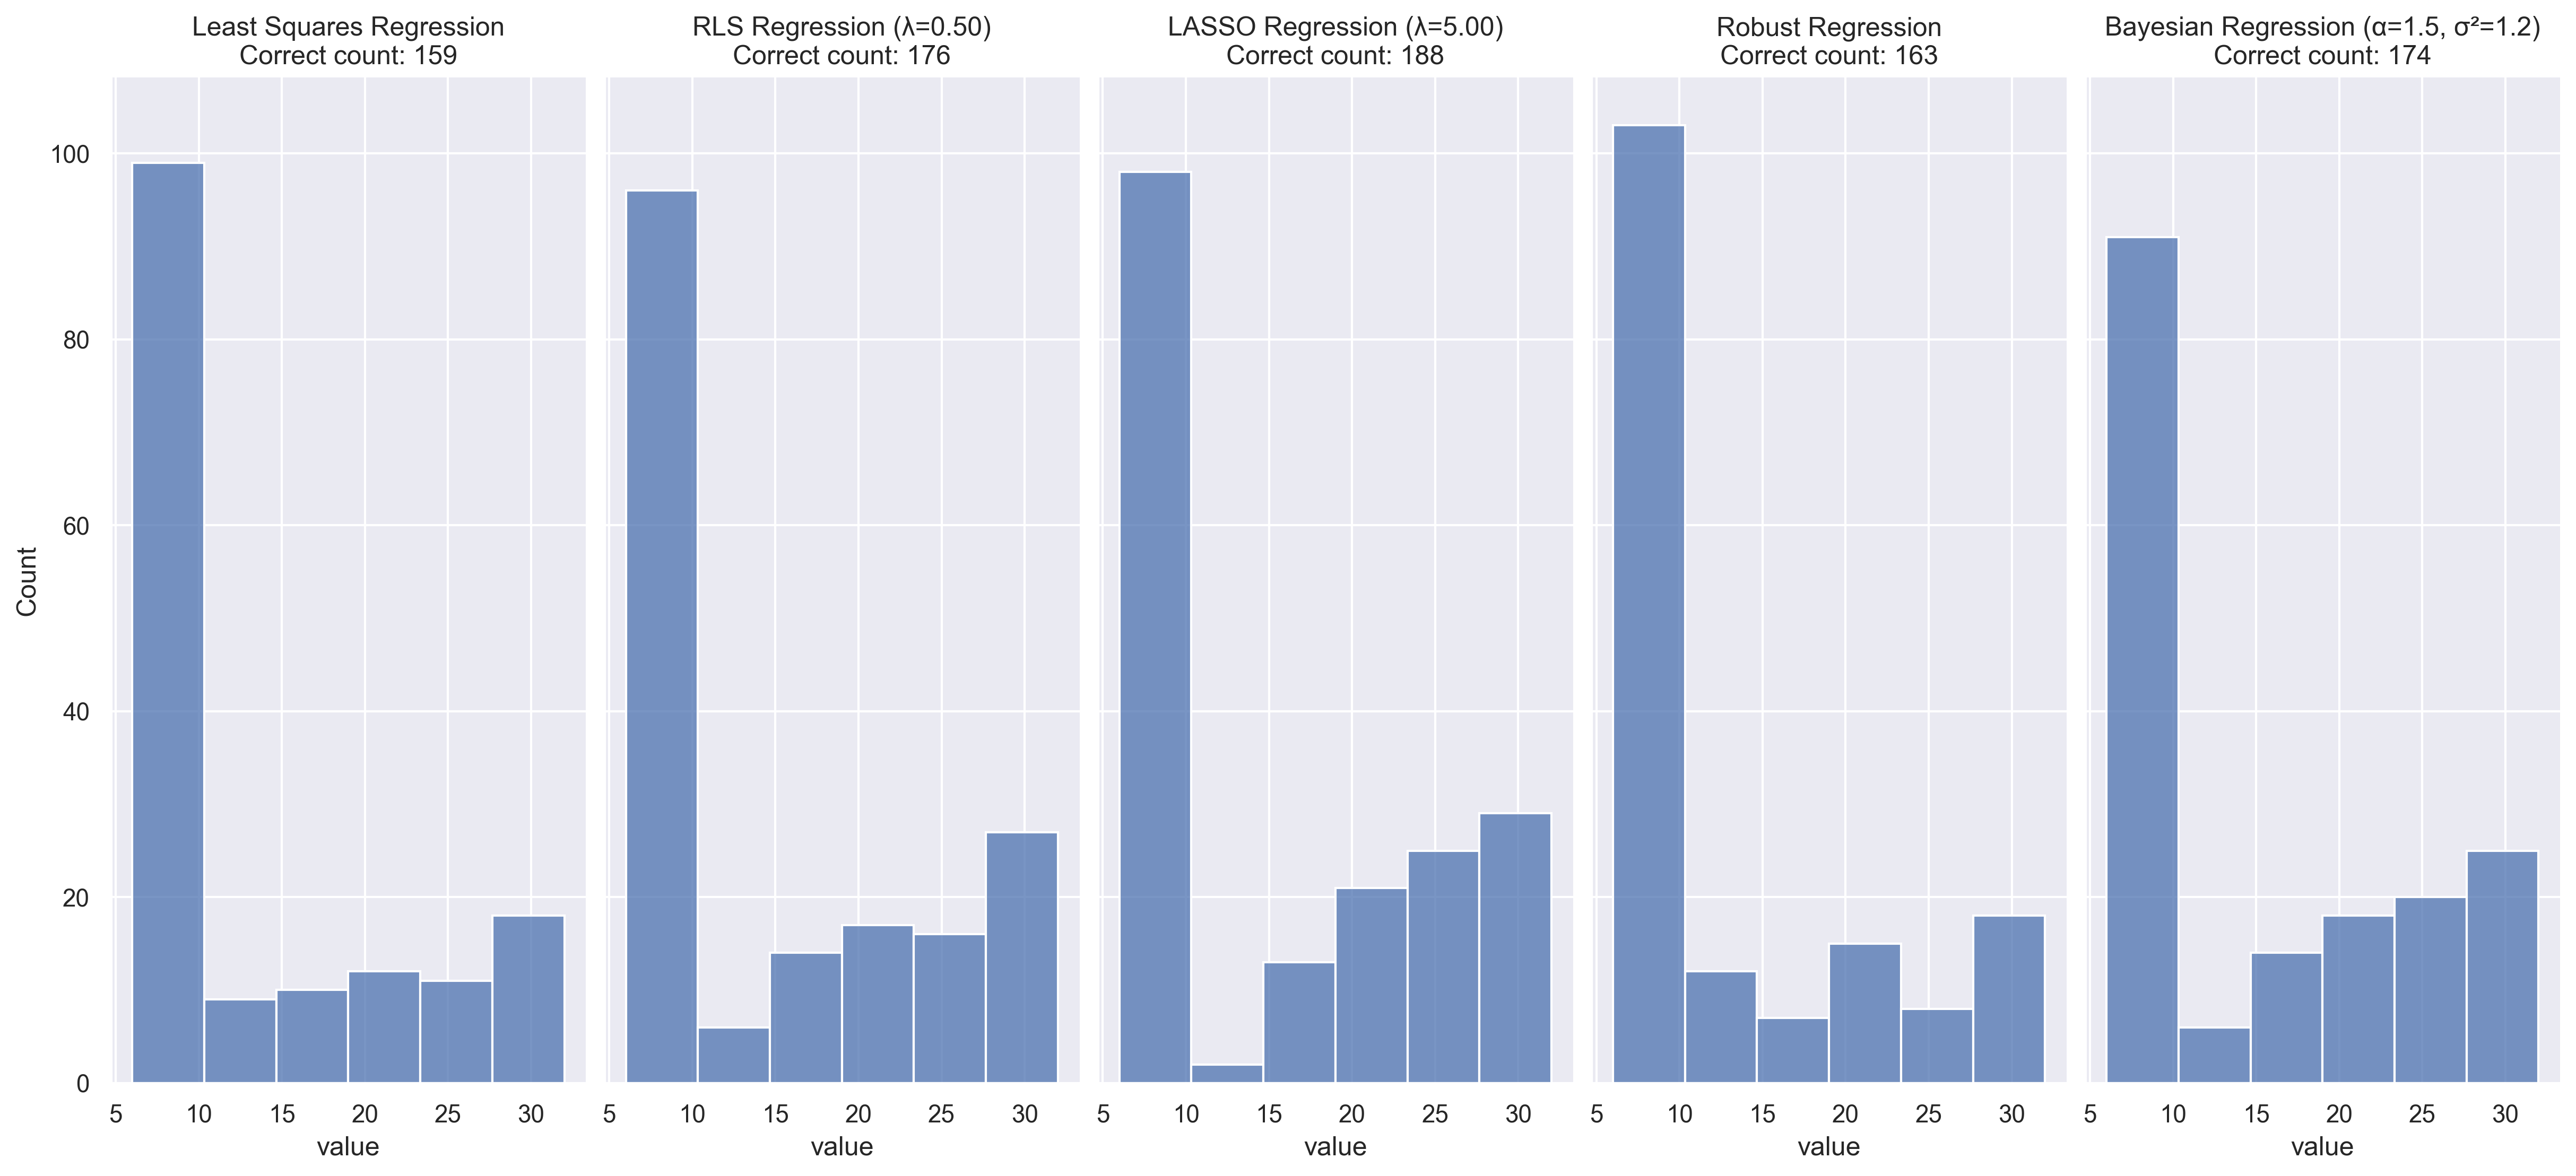

In [20]:
models_2b = [LS(), RLS(l=3), LASSO(l=3), RR(), BR(alpha=1, sigma_2=2.5)]
# maps (x1, ..., x9) to (x1, ..., x9, x1^2, ..., x9^2)
poly_2 = lambda x: np.concatenate((x, x**2))
fit_predict_plot_2a(models_2a, phi=poly_2)

Least Squares Regression
MAE=1.4433,    MSE=3.7500,    R²=0.9453
----------------------------------------
RLS Regression (λ=3.00)
MAE=1.1400,    MSE=2.5600,    R²=0.9627
----------------------------------------
LASSO Regression (λ=3.00)
MAE=1.1883,    MSE=2.6917,    R²=0.9608
----------------------------------------


Robust Regression
MAE=1.4867,    MSE=3.9100,    R²=0.9430
----------------------------------------
Bayesian Regression (α=1.0, σ²=2.5)
MAE=1.1567,    MSE=2.6333,    R²=0.9616
----------------------------------------


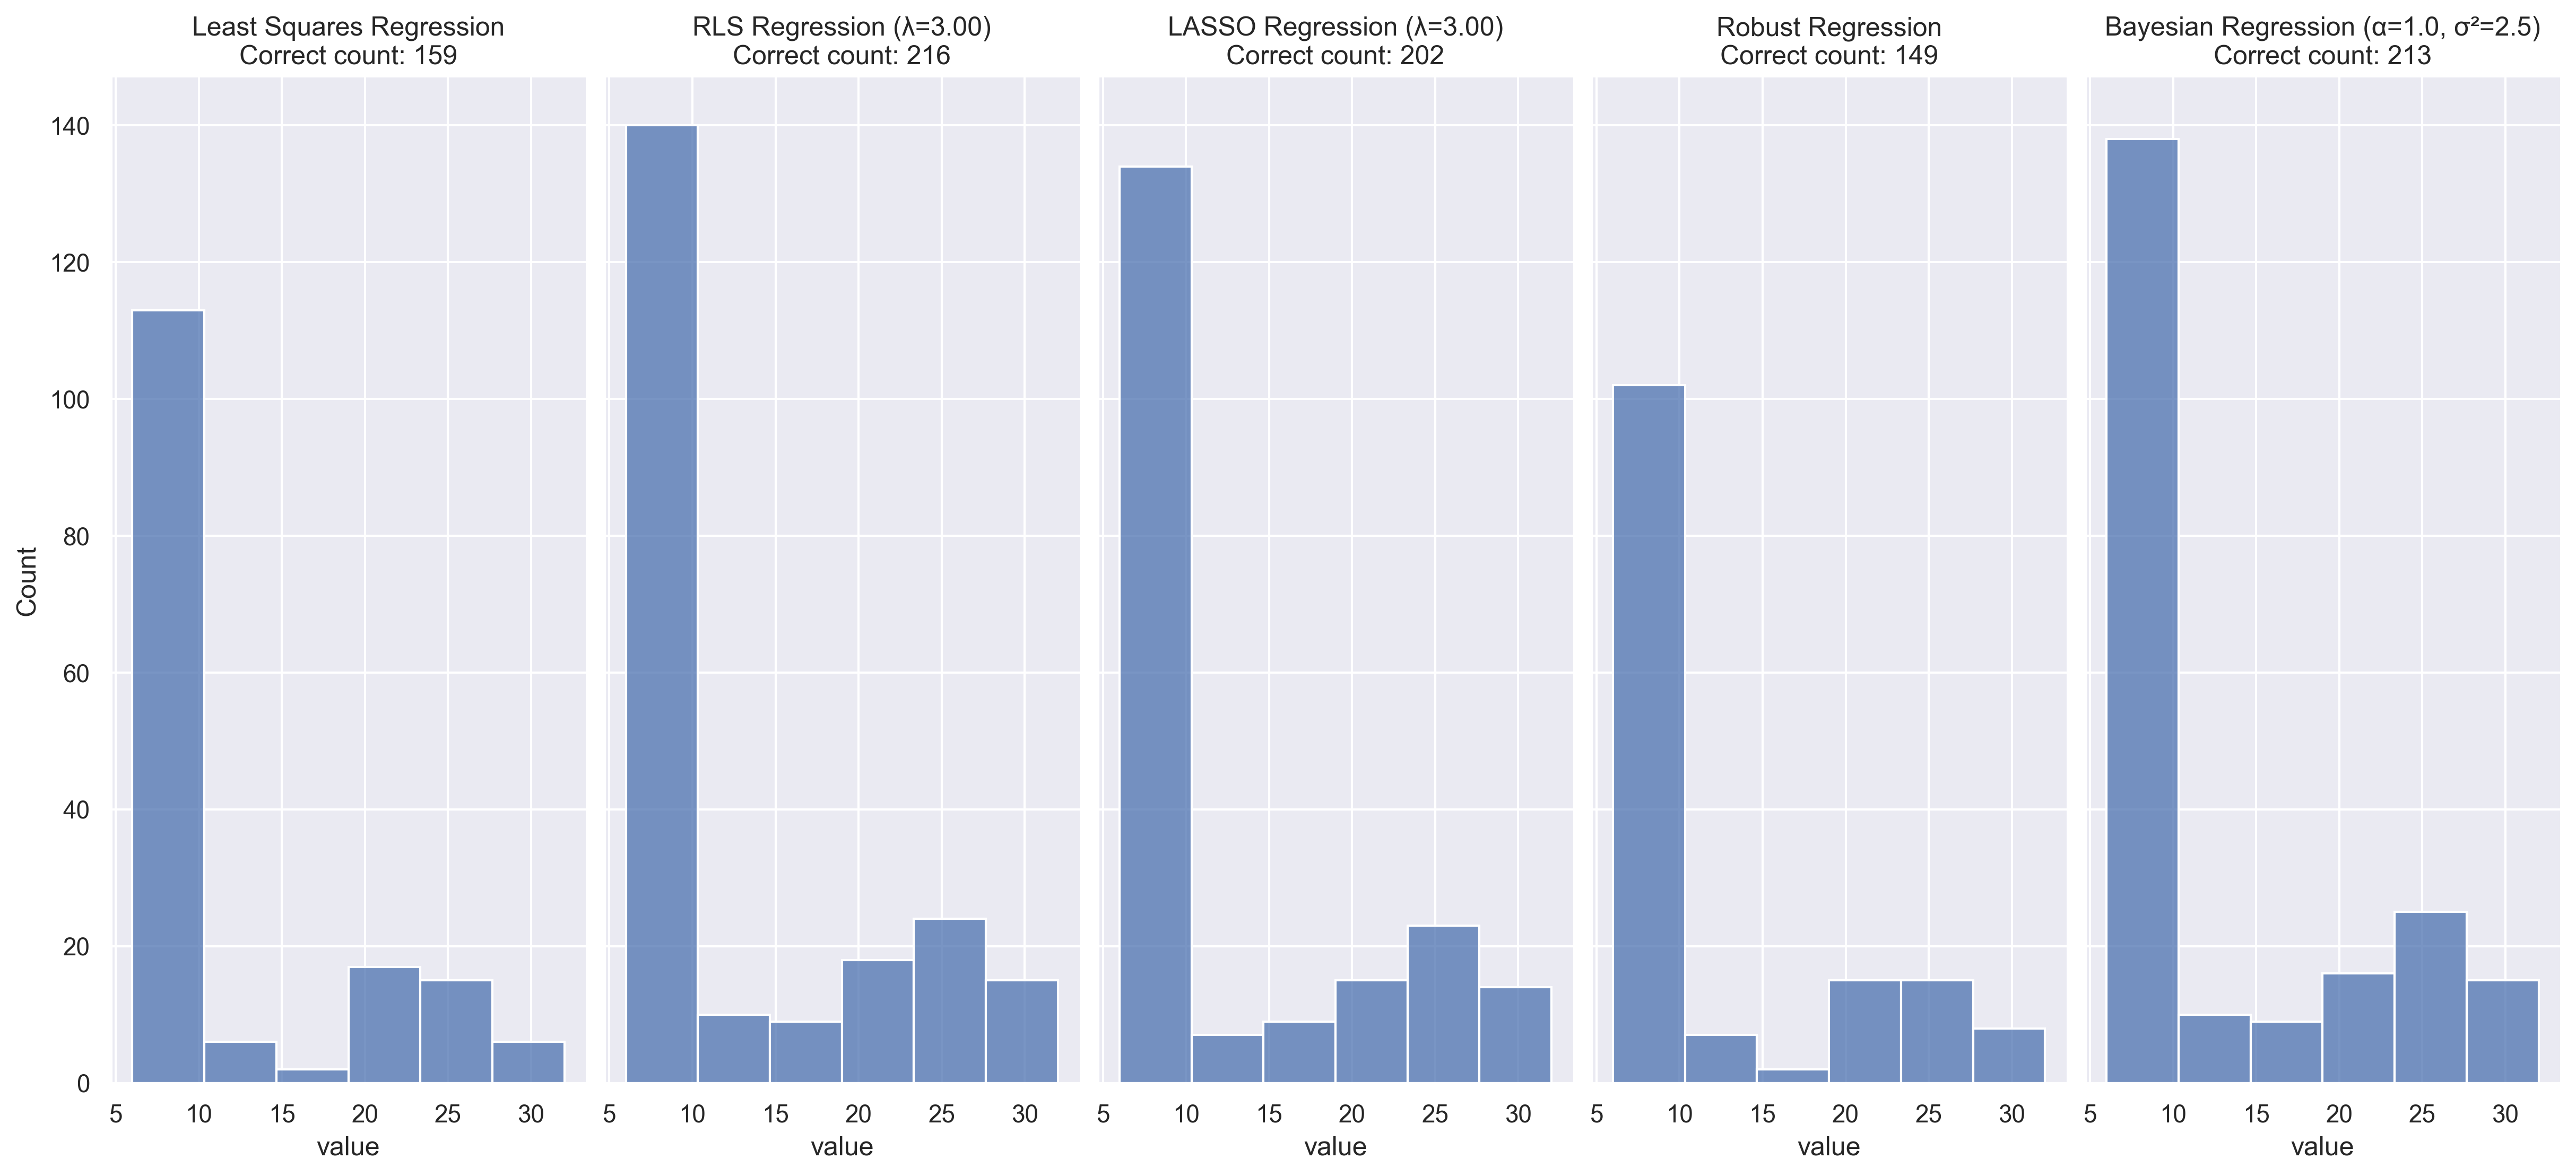

In [21]:
phi = lambda x: np.concatenate((
    x, x**2, x**3 / 2, x**4 / 24,
    np.exp(x[:1] * x[1:]),
))
fit_predict_plot_2a(models_2b, phi=phi)

Least Squares Regression
MAE=1.3983,    MSE=3.6450,    R²=0.9469
----------------------------------------
RLS Regression (λ=3.00)
MAE=1.2367,    MSE=2.8900,    R²=0.9579
----------------------------------------
LASSO Regression (λ=3.00)
MAE=1.2533,    MSE=2.9200,    R²=0.9574
----------------------------------------
Robust Regression
MAE=1.4950,    MSE=4.4517,    R²=0.9351
----------------------------------------
Bayesian Regression (α=1.0, σ²=2.5)
MAE=1.2400,    MSE=2.9167,    R²=0.9575
----------------------------------------


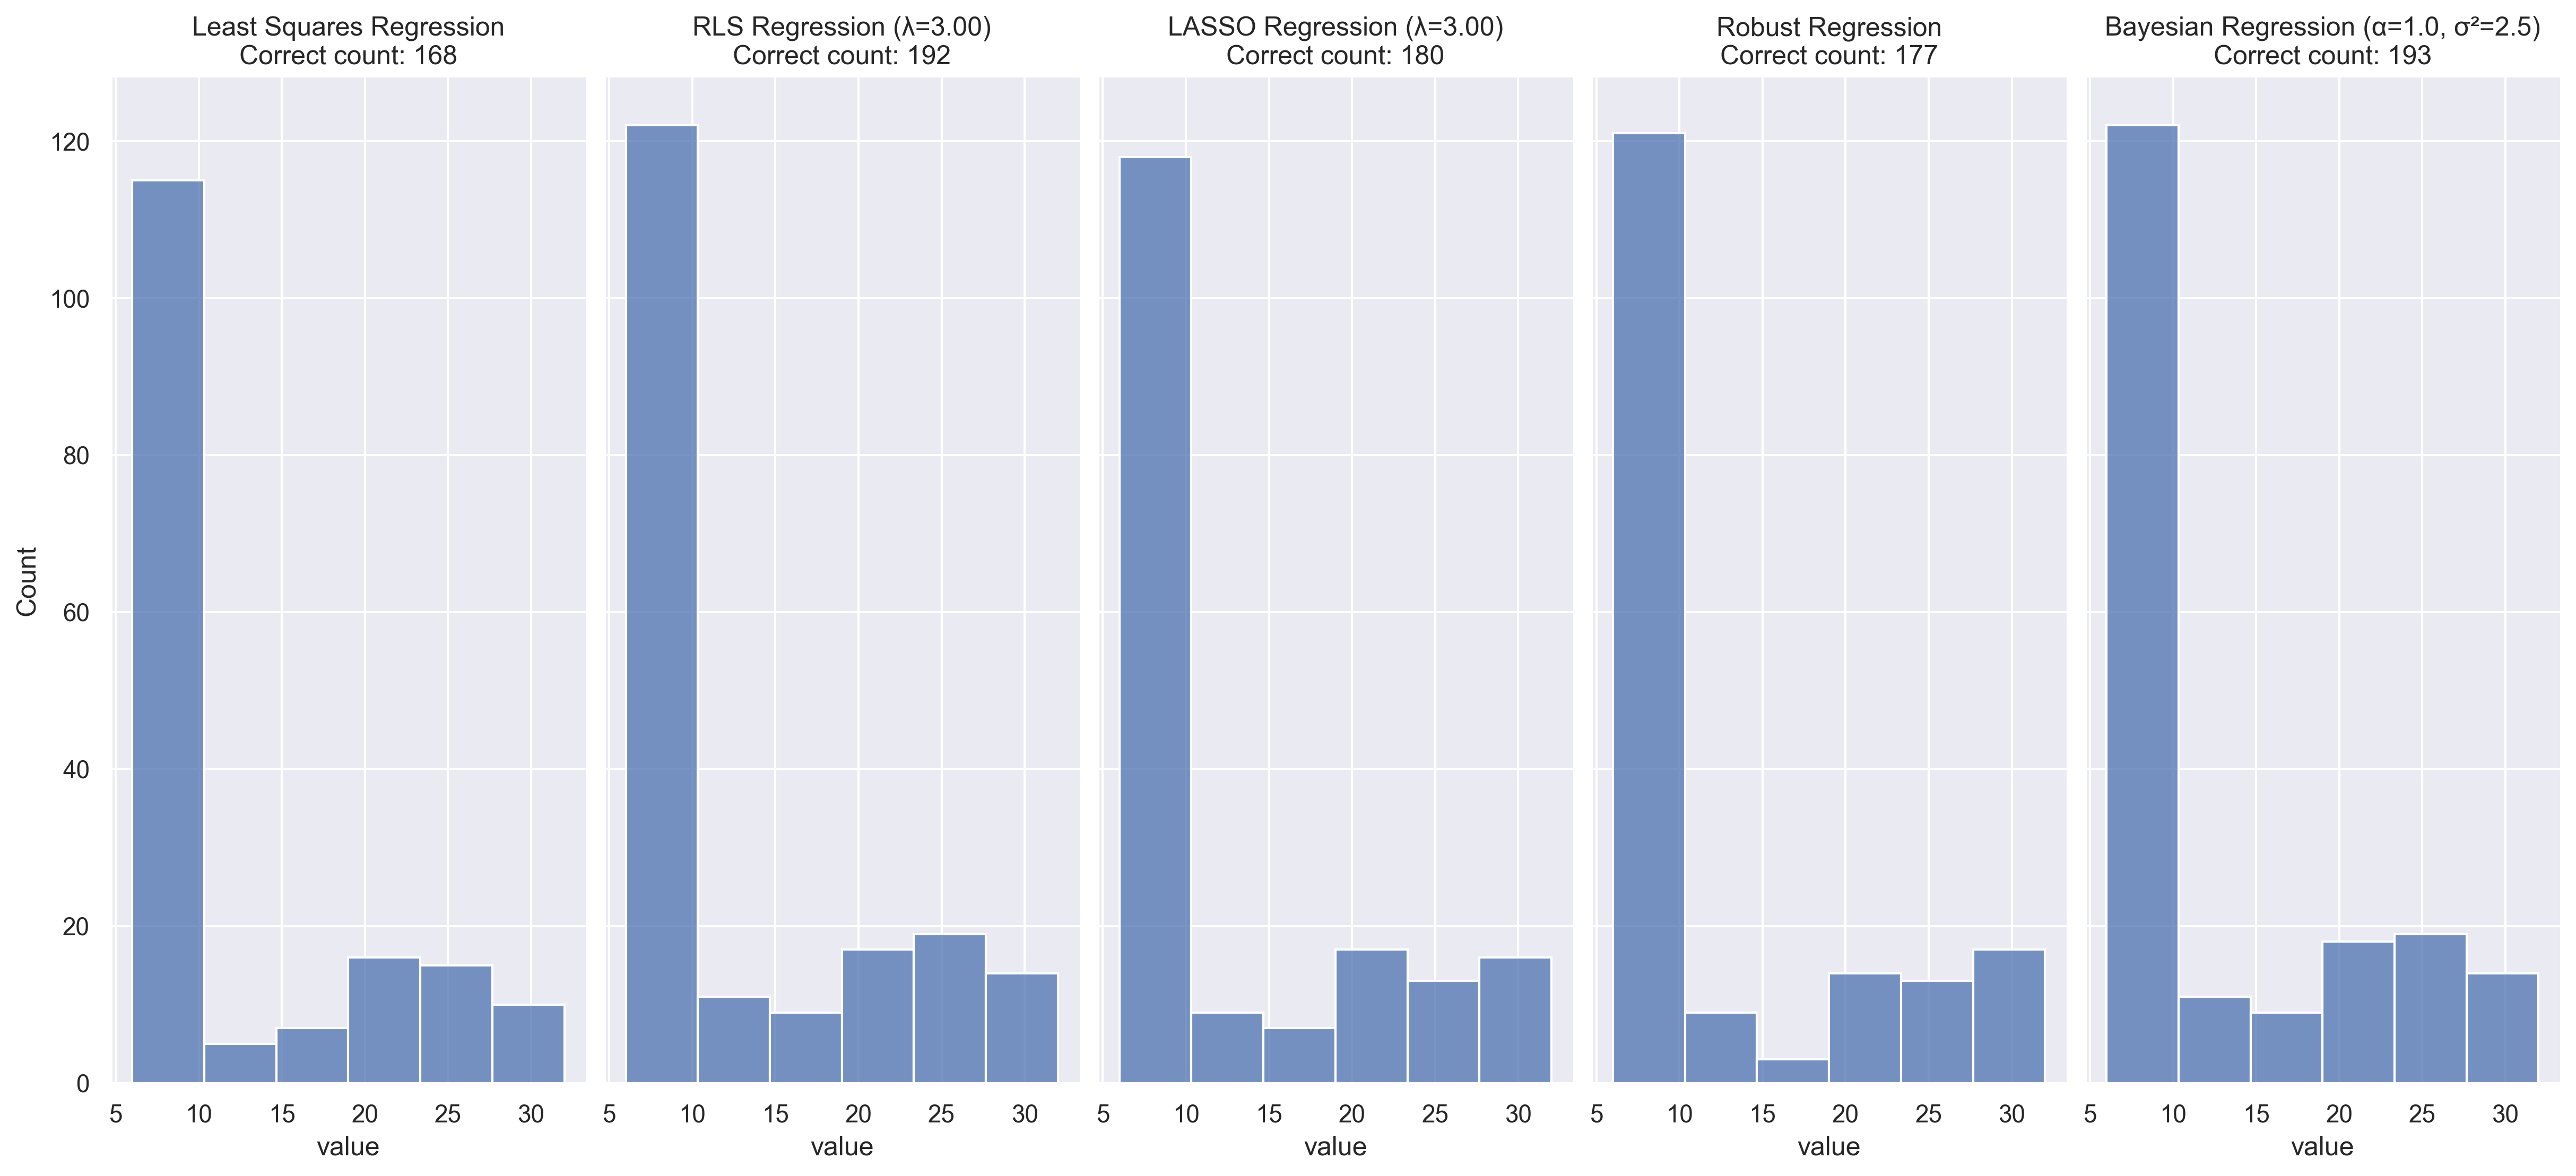

In [22]:
phi = lambda x: np.concatenate((
    x, x**2, x**3,
    np.exp(np.outer(x, x)[np.triu_indices(x.size, 1)]),
    np.cumsum(np.sin(x)),
))
fit_predict_plot_2a(models_2b, phi=phi)

## Part 3: Estimating hyperparameters

Here, we opt to estimate the most performant hyperparameters by k-fold cross validation on the training set. We evaluate a model performance through three metrics: the number of correct predictions, the mean absolute error, and the mean squared error. 

In [23]:
def cross_validation(models, phi, X, y, k=5, seed=12):
    n = y.size
    indices = np.arange(n)

    rng = np.random.default_rng(seed)
    rng.shuffle(indices)
    fold_size = n // k

    results = []

    for i in range(k):
        test_indices = indices[i*fold_size:(i+1)*fold_size]
        train_indices = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        X_train, X_test = X[:, train_indices], X[:, test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        for model in models:
            mae, mse, correct_predicts, _ = fit_predict_2a(model, phi, X_train, y_train, X_test, y_test)
            results.append((i, model.hyperparam(), mae, mse, correct_predicts.size))

    df = pd.DataFrame(results, columns=["iter", "model", "mae", "mse", "correct_count"])
    return df

def estimate_hyperparam_kfold(models, phi, k=5, seed=12):
    df = cross_validation(models, phi, X_train_2, y_train_2, k=k, seed=seed)
    mse = df.groupby("model", sort=False)["mse"].mean().reset_index()["mse"].to_numpy()
    mae = df.groupby("model", sort=False)["mae"].mean().reset_index()["mae"].to_numpy()
    correct_count = df.groupby("model", sort=False)["correct_count"].mean().reset_index()["correct_count"].to_numpy()

    hyperparams = [model.hyperparam() for model in models]
    if not isinstance(hyperparams[0], tuple):
        fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True, layout="constrained")
        axs[2].xaxis.set_ticks(np.arange(0, 10.1, 0.5))
        sns.lineplot(x=hyperparams, y=mse, ax=axs[0]).set_title("Mean squared error")
        sns.lineplot(x=hyperparams, y=mae, ax=axs[1]).set_title("Mean absolute error")
        sns.lineplot(x=hyperparams, y=correct_count, ax=axs[2]).set_title("Correct count")
        axs[2].set_xlabel("λ")
    else:
        alpha = np.unique([hp[0] for hp in hyperparams])
        sigma_2 = np.unique([hp[1] for hp in hyperparams])
        fig, axs = plt.subplots(1, 3, figsize=(16, 8))
        sns.heatmap(mse.reshape((alpha.size, -1)), yticklabels=alpha, xticklabels=sigma_2, ax=axs[0]).set_title("Mean squared error")
        sns.heatmap(mae.reshape((alpha.size, -1)), yticklabels=alpha, xticklabels=sigma_2, ax=axs[1]).set_title("Mean absolute error")
        sns.heatmap(correct_count.reshape((alpha.size, -1)), yticklabels=alpha, xticklabels=sigma_2, ax=axs[2]).set_title("Correct predictions")
        for ax in axs:
            ax.tick_params(rotation=0)


    indices = np.argwhere(correct_count == np.max(correct_count)).flatten()
    if indices.size > 1:
        indices = indices[np.argwhere(mae[indices] == np.min(mae[indices]))].flatten()
    if indices.size > 1:
        indices = indices[np.argwhere(mse[indices] == np.max(mse[indices]))].flatten()

    best_model = models[indices[0]]
    print(f"Best model: {best_model.title}")
    return best_model

In [24]:
phi = lambda x: np.concatenate((
    x, x**2, x**3 / 2, x**4 / 24,
    np.exp(x[:1] * x[1:])
))

Best model: RLS Regression (λ=0.10)


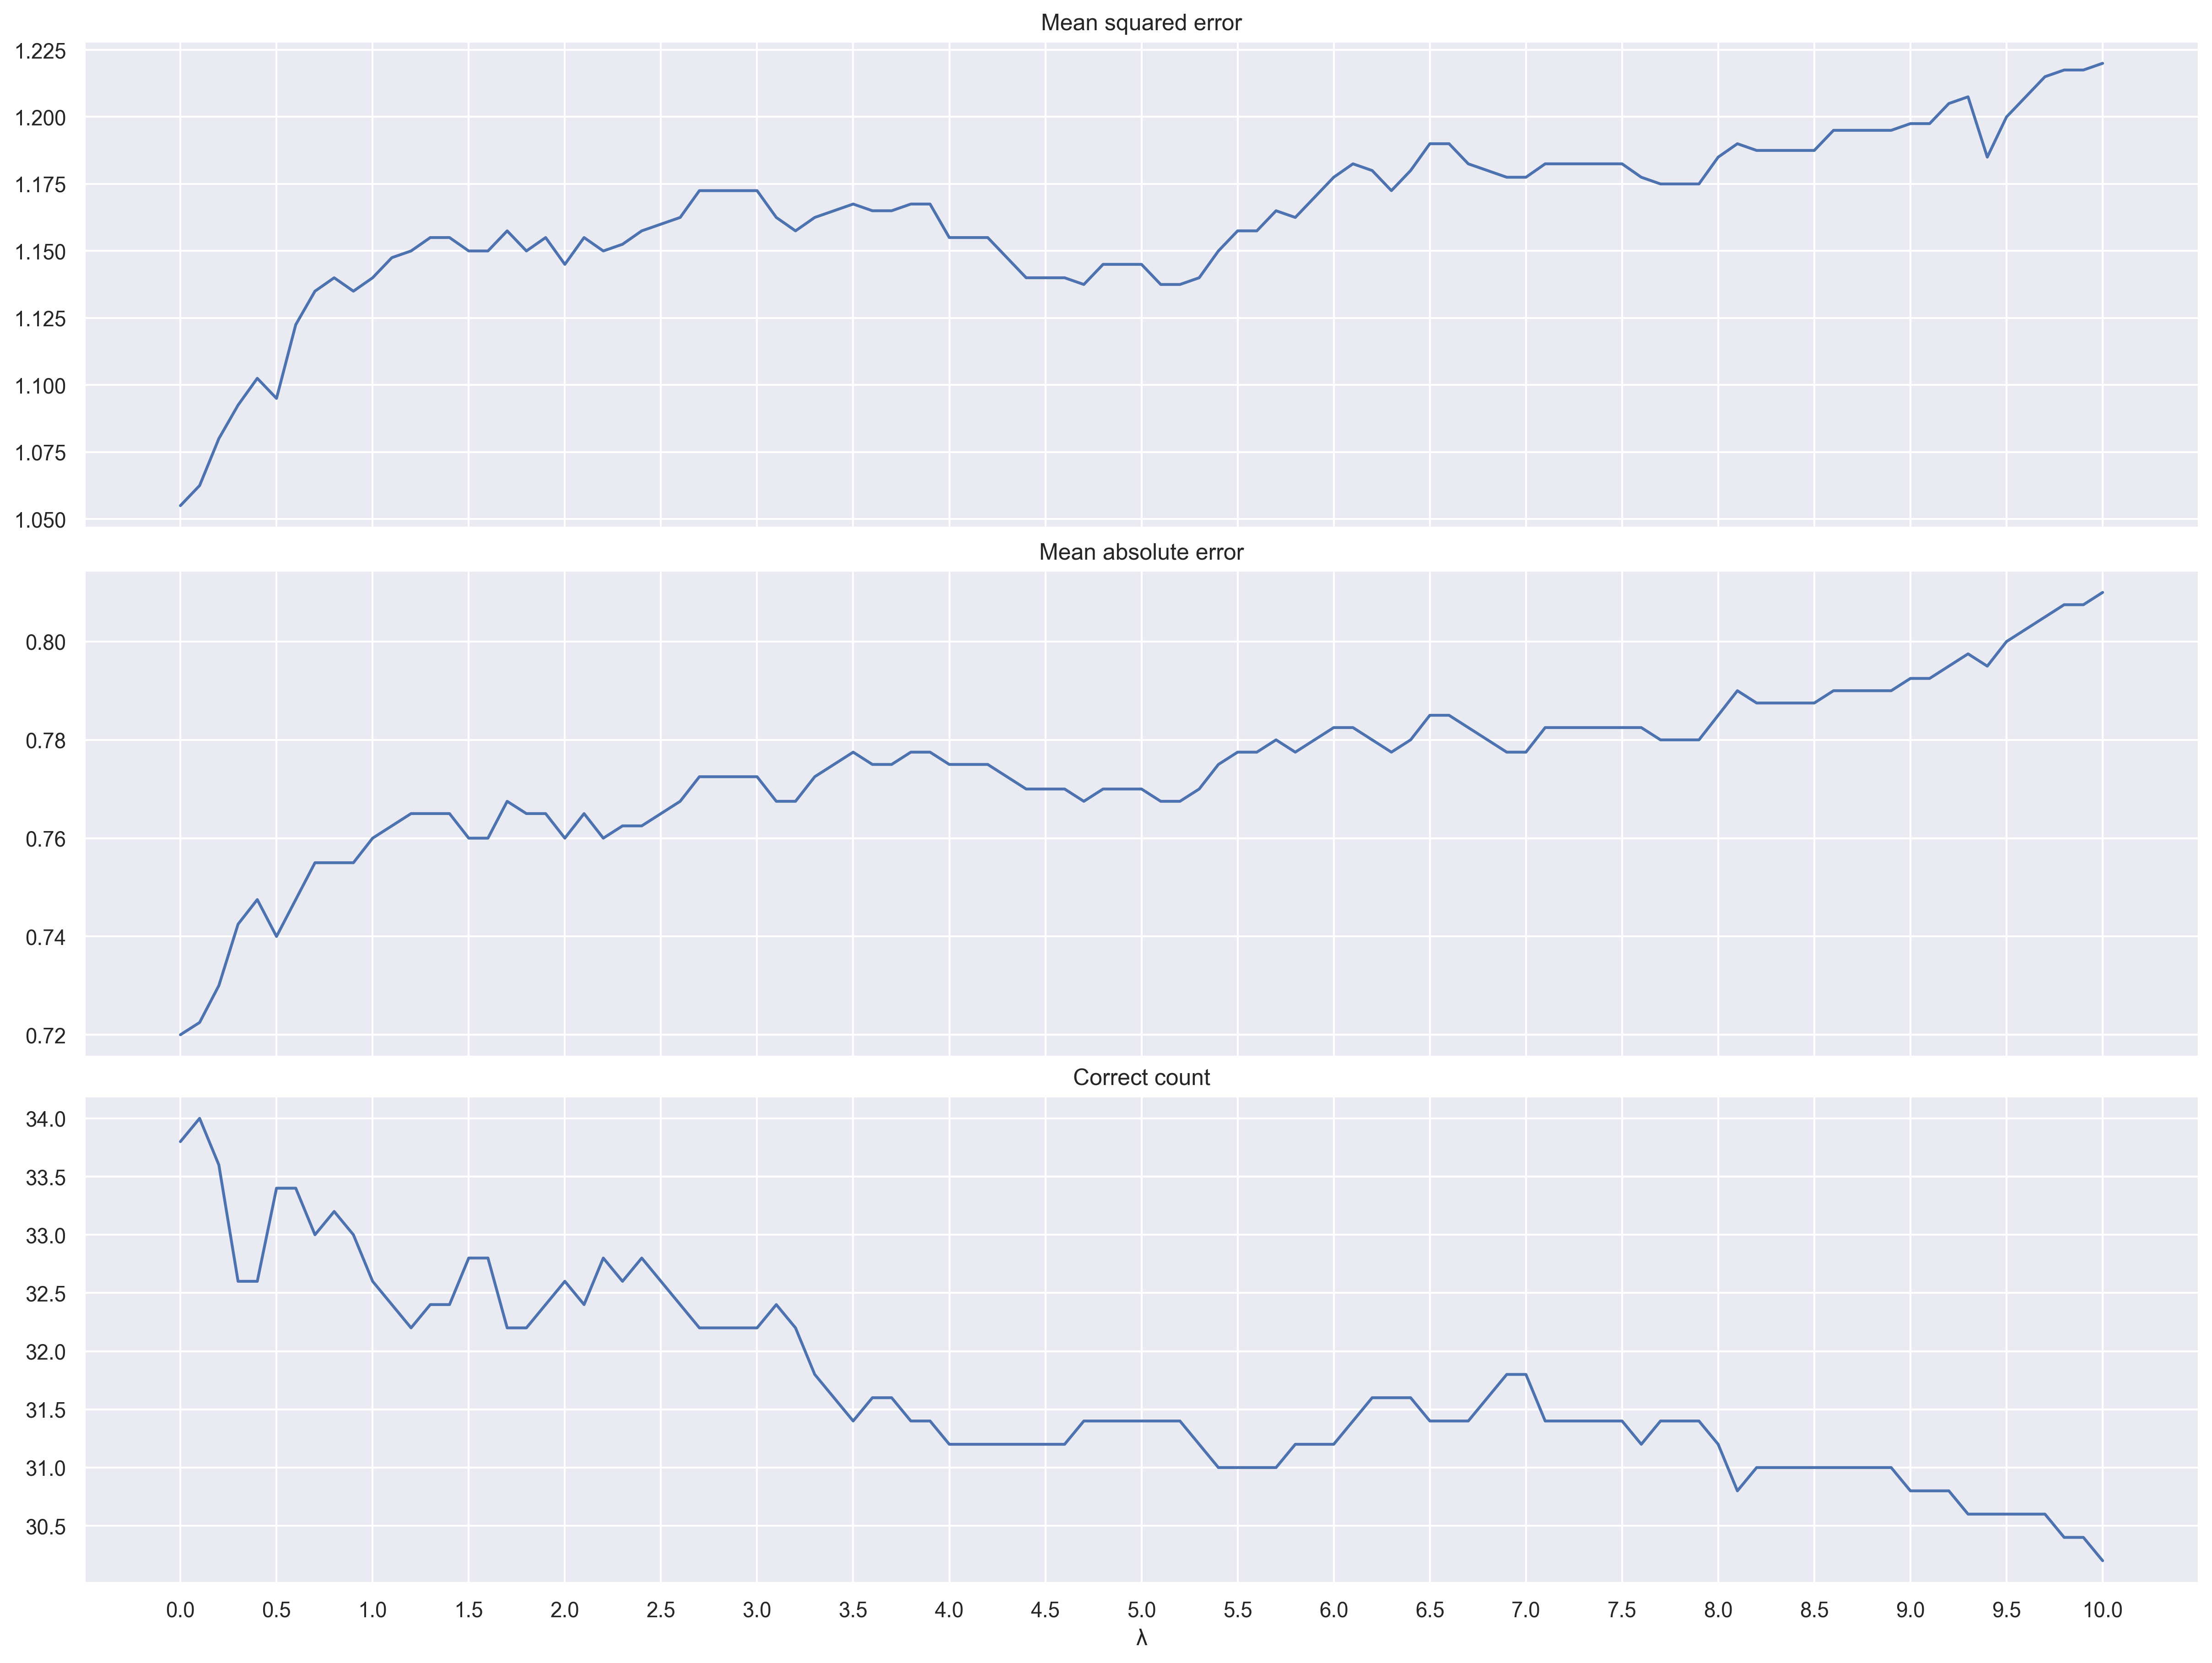

In [25]:
rls_models = [RLS(l) for l in np.arange(0, 10.1, 0.1)]
best_rls = estimate_hyperparam_kfold(rls_models, phi=phi, k=5)

Best model: LASSO Regression (λ=0.40)


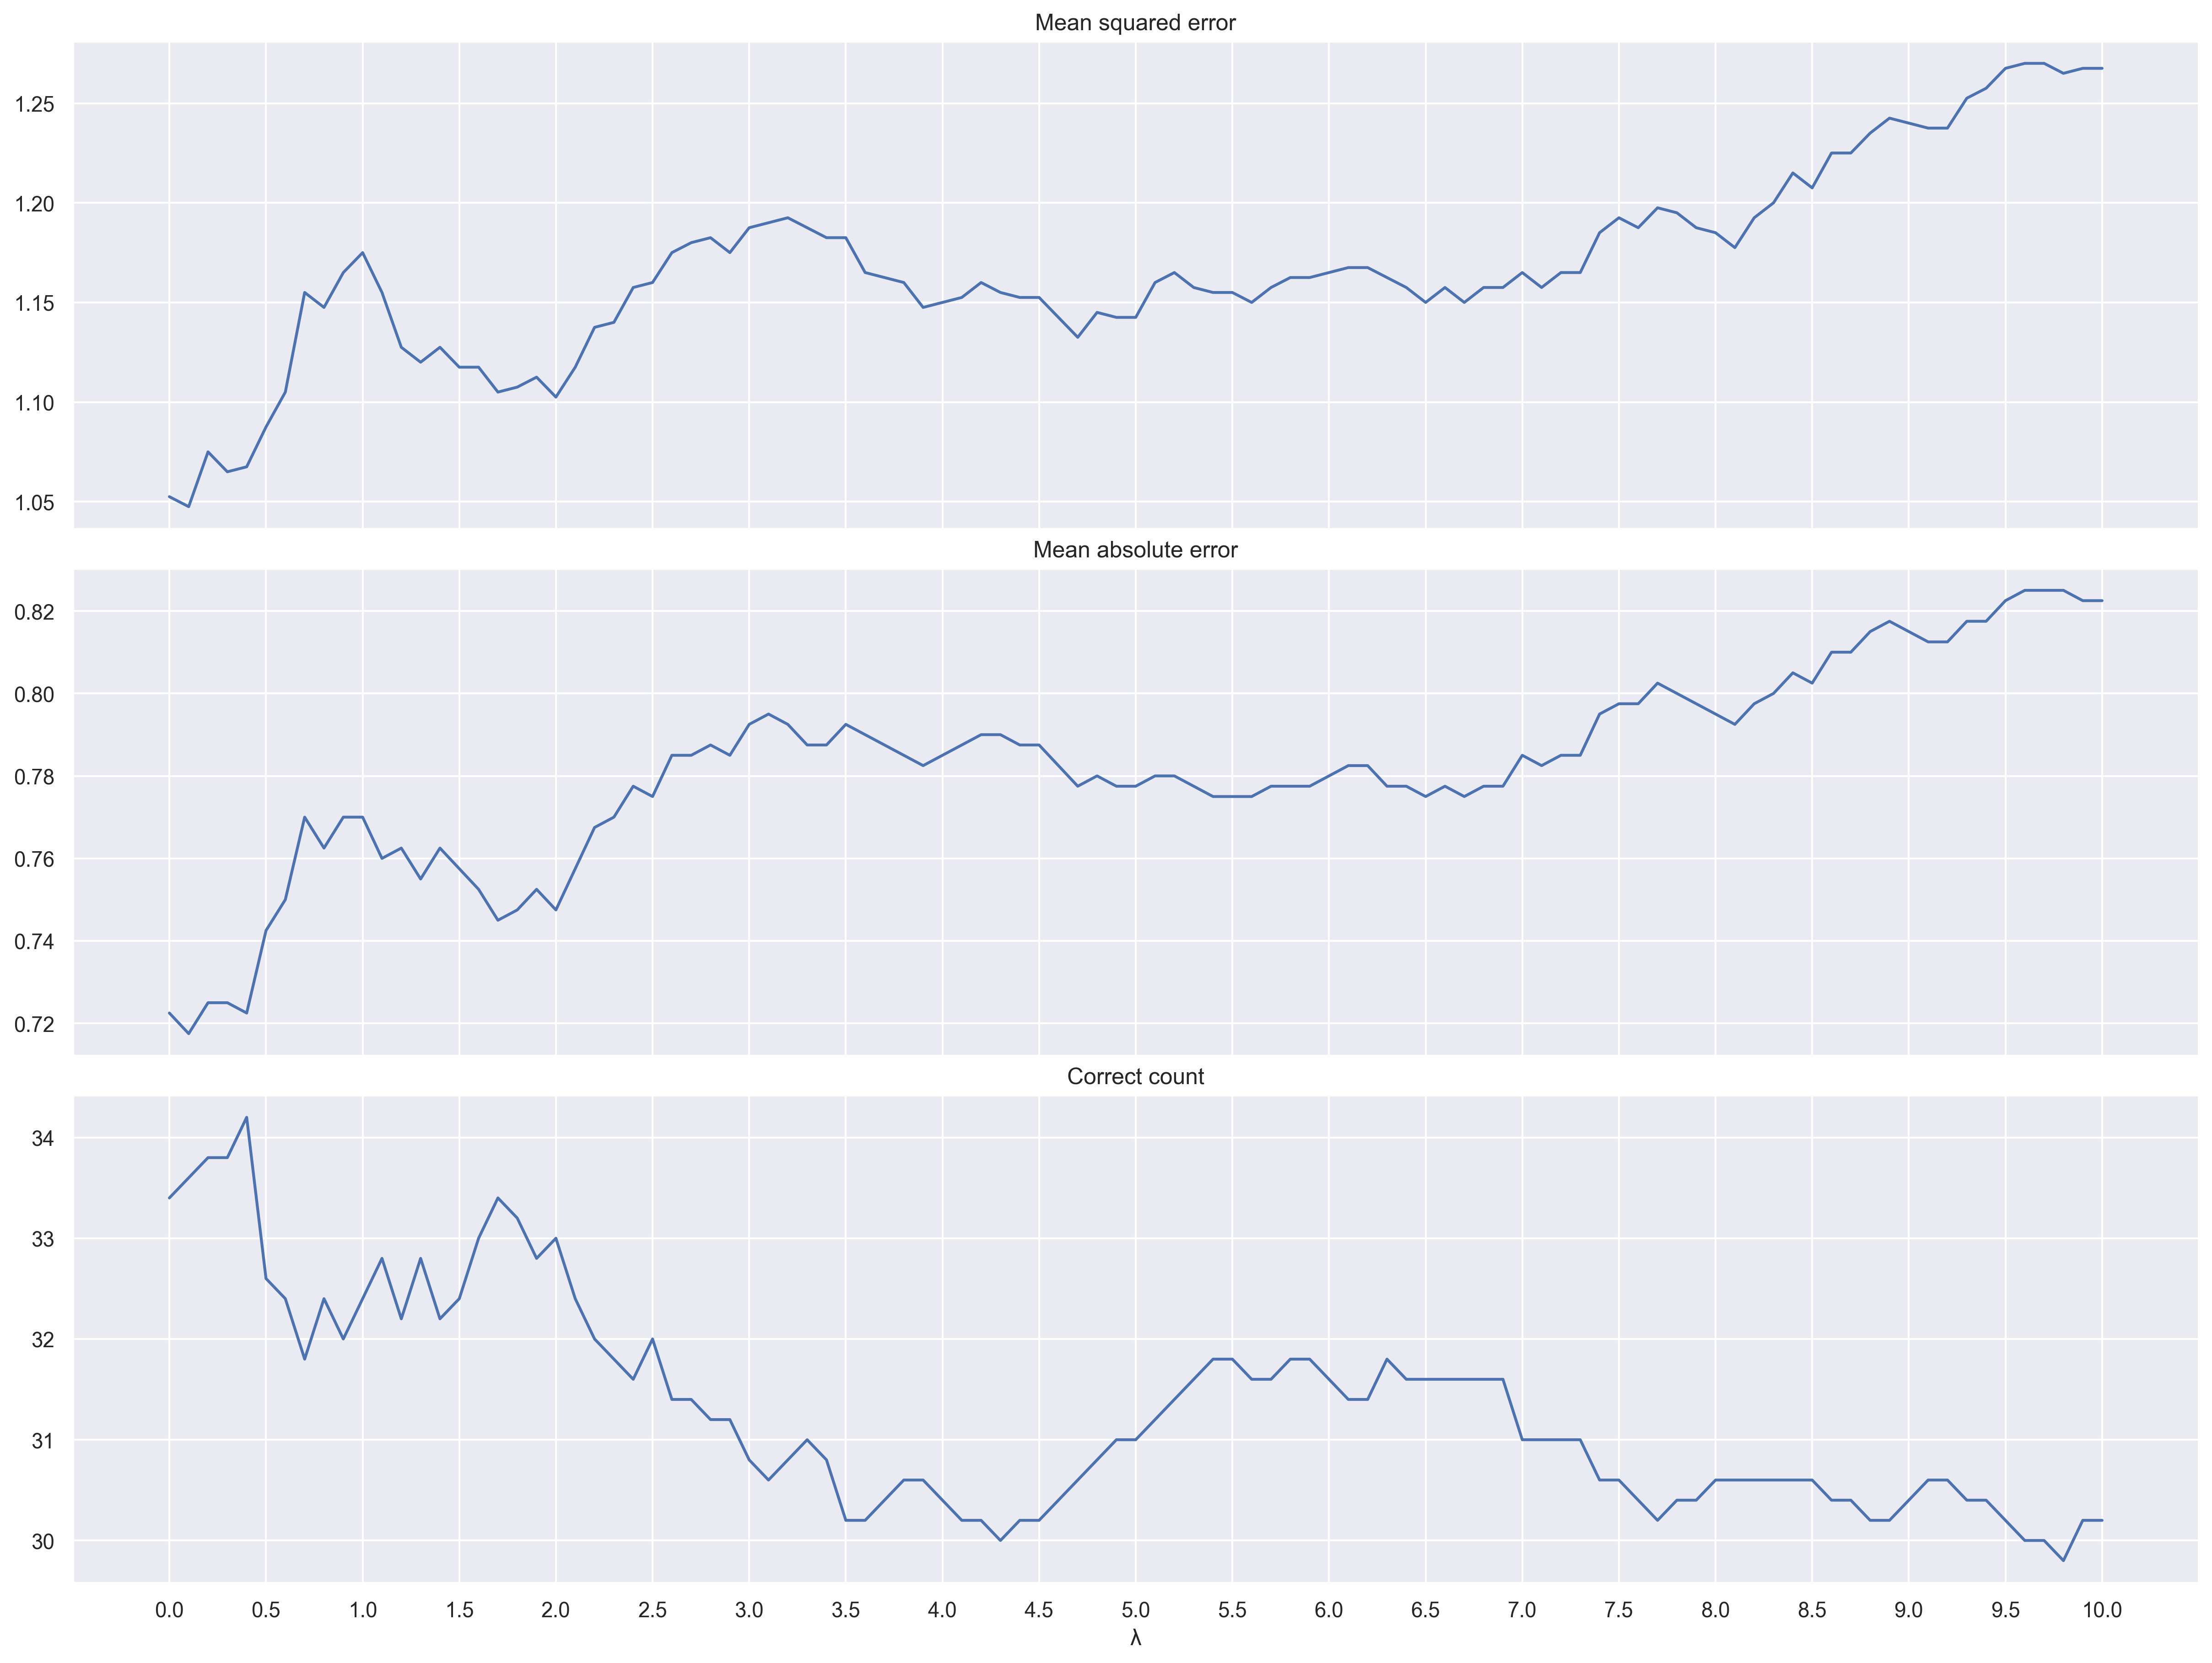

In [26]:
lasso_models = [LASSO(l) for l in np.arange(0, 10.1, 0.1)]
best_lasso = estimate_hyperparam_kfold(lasso_models, phi=phi, k=5)

Best model: Bayesian Regression (α=1.0, σ²=0.1)


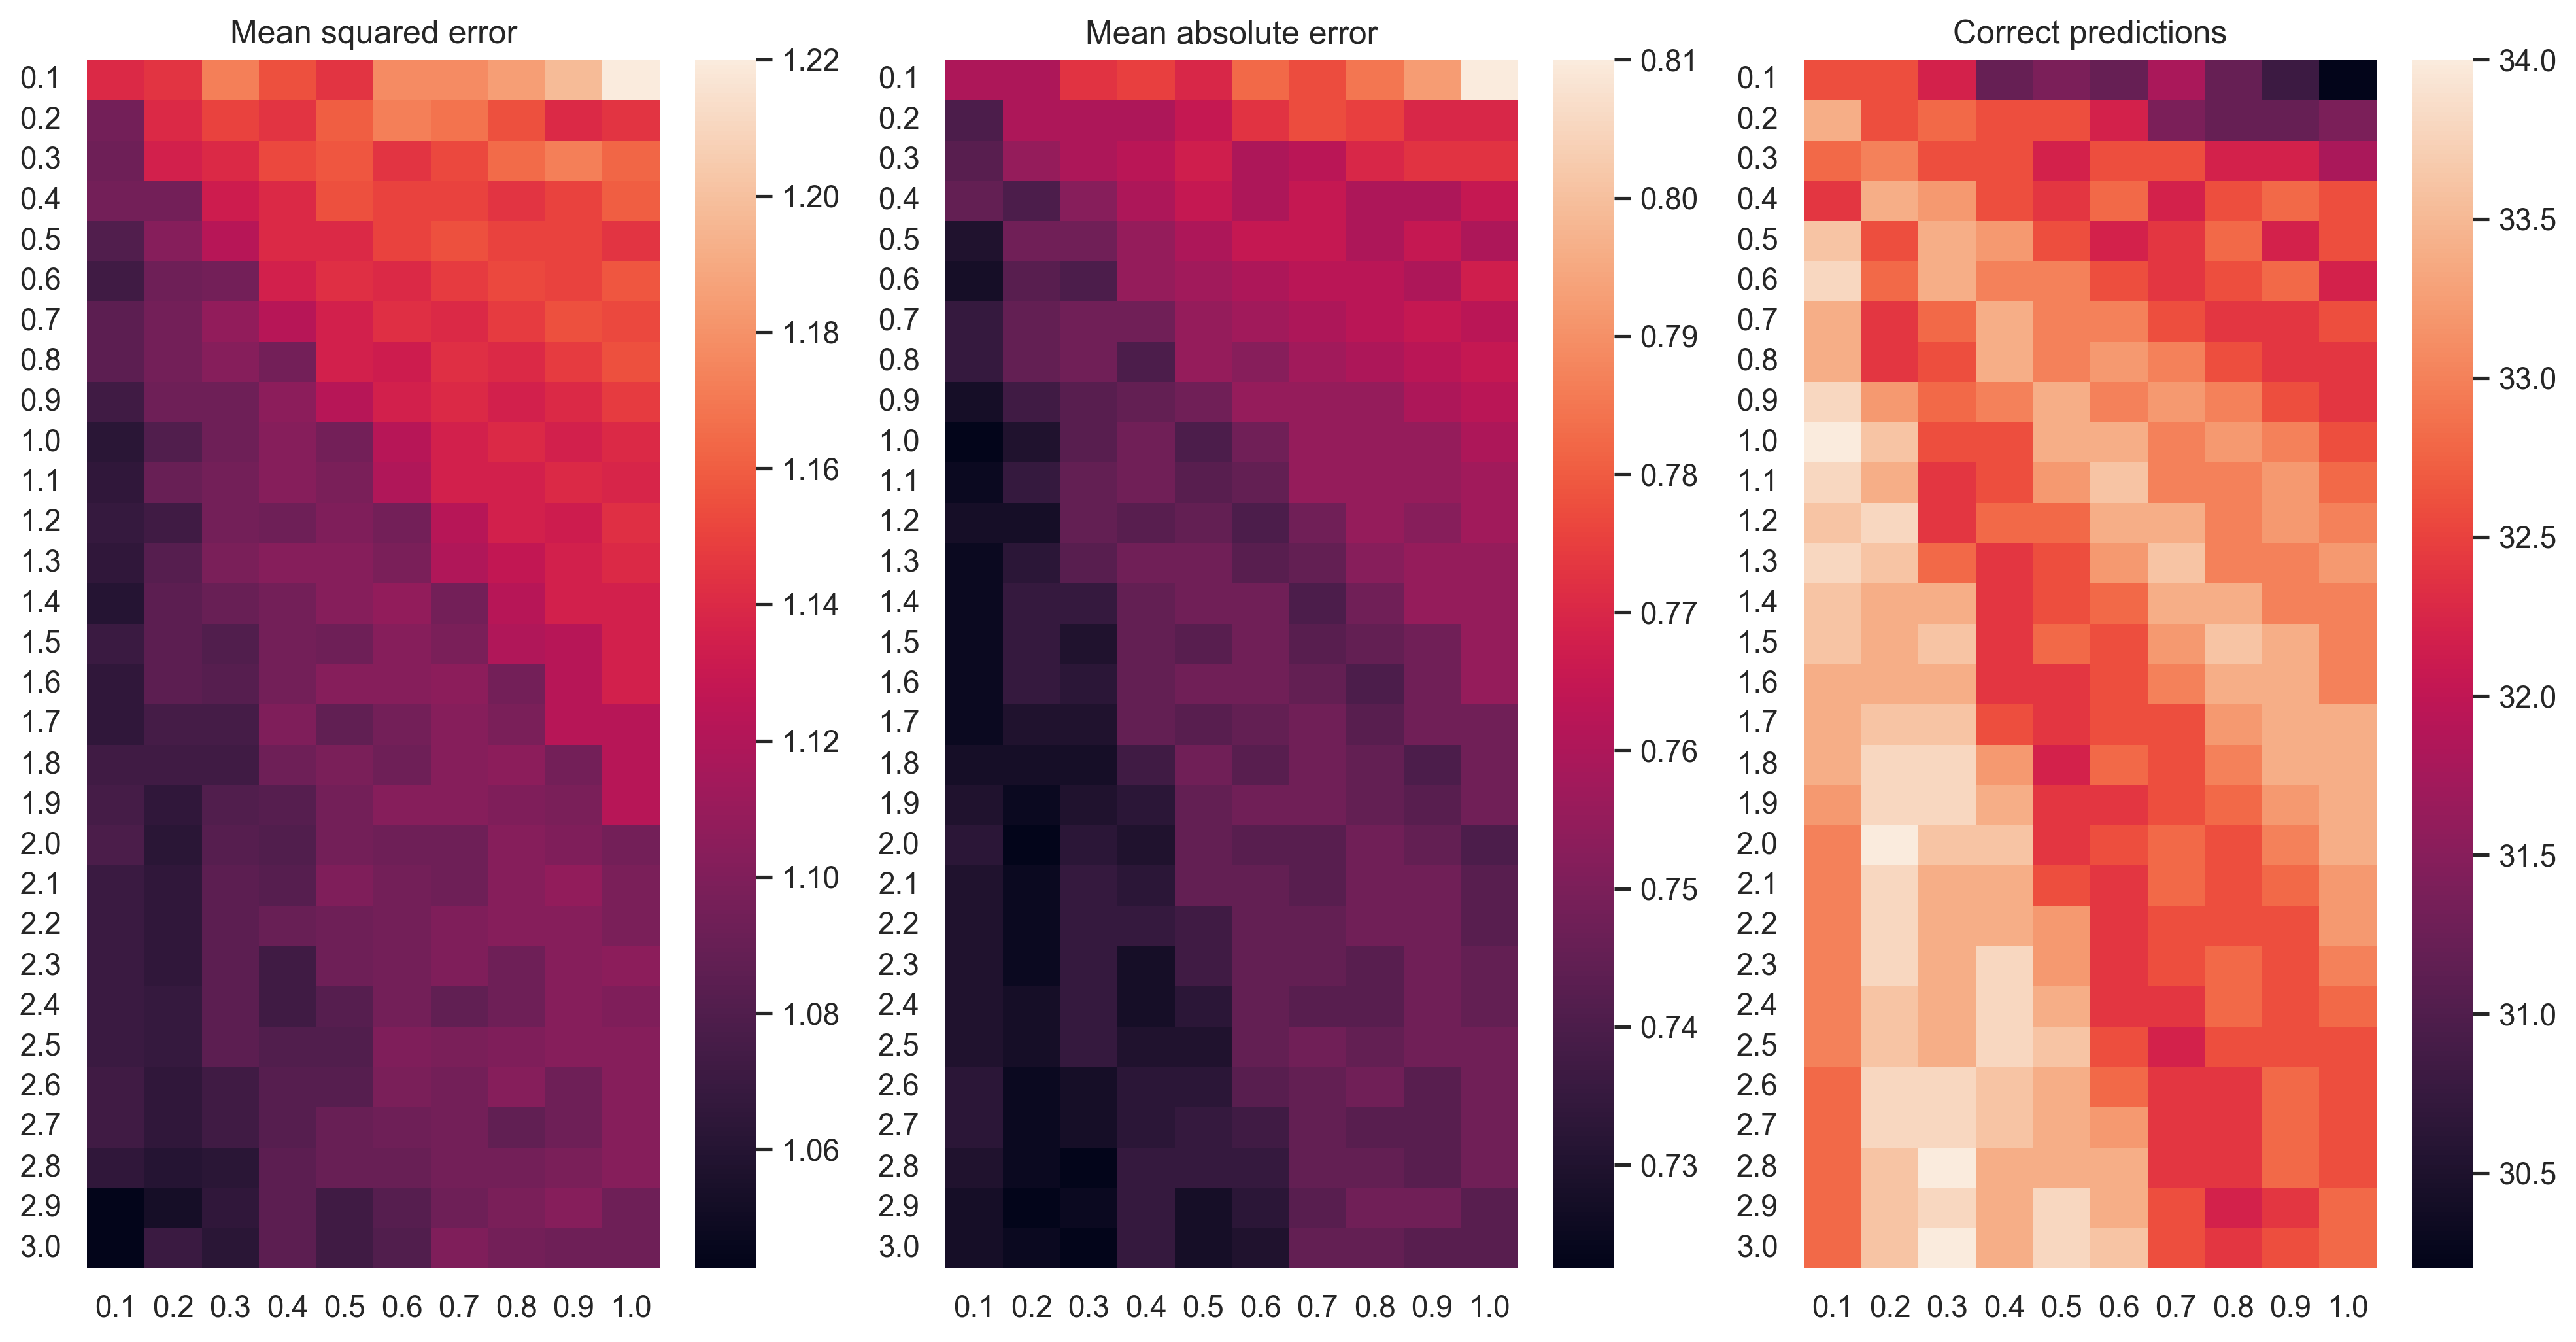

In [27]:
bayes_models = [BR(alpha, sigma_2) for alpha in np.arange(1, 31) / 10 for sigma_2 in np.arange(1, 11) / 10]
best_bayes = estimate_hyperparam_kfold(bayes_models, phi=phi, k=5)

Having identified the three best models using cross validation, we now test them as before. The results are not bad but still a little worse than our hand-picked hyperparameters.

RLS Regression (λ=0.10)
MAE=1.3617,    MSE=3.4550,    R²=0.9496
----------------------------------------
LASSO Regression (λ=0.40)
MAE=1.3067,    MSE=3.2767,    R²=0.9522
----------------------------------------
Bayesian Regression (α=1.0, σ²=0.1)
MAE=1.3617,    MSE=3.4550,    R²=0.9496
----------------------------------------


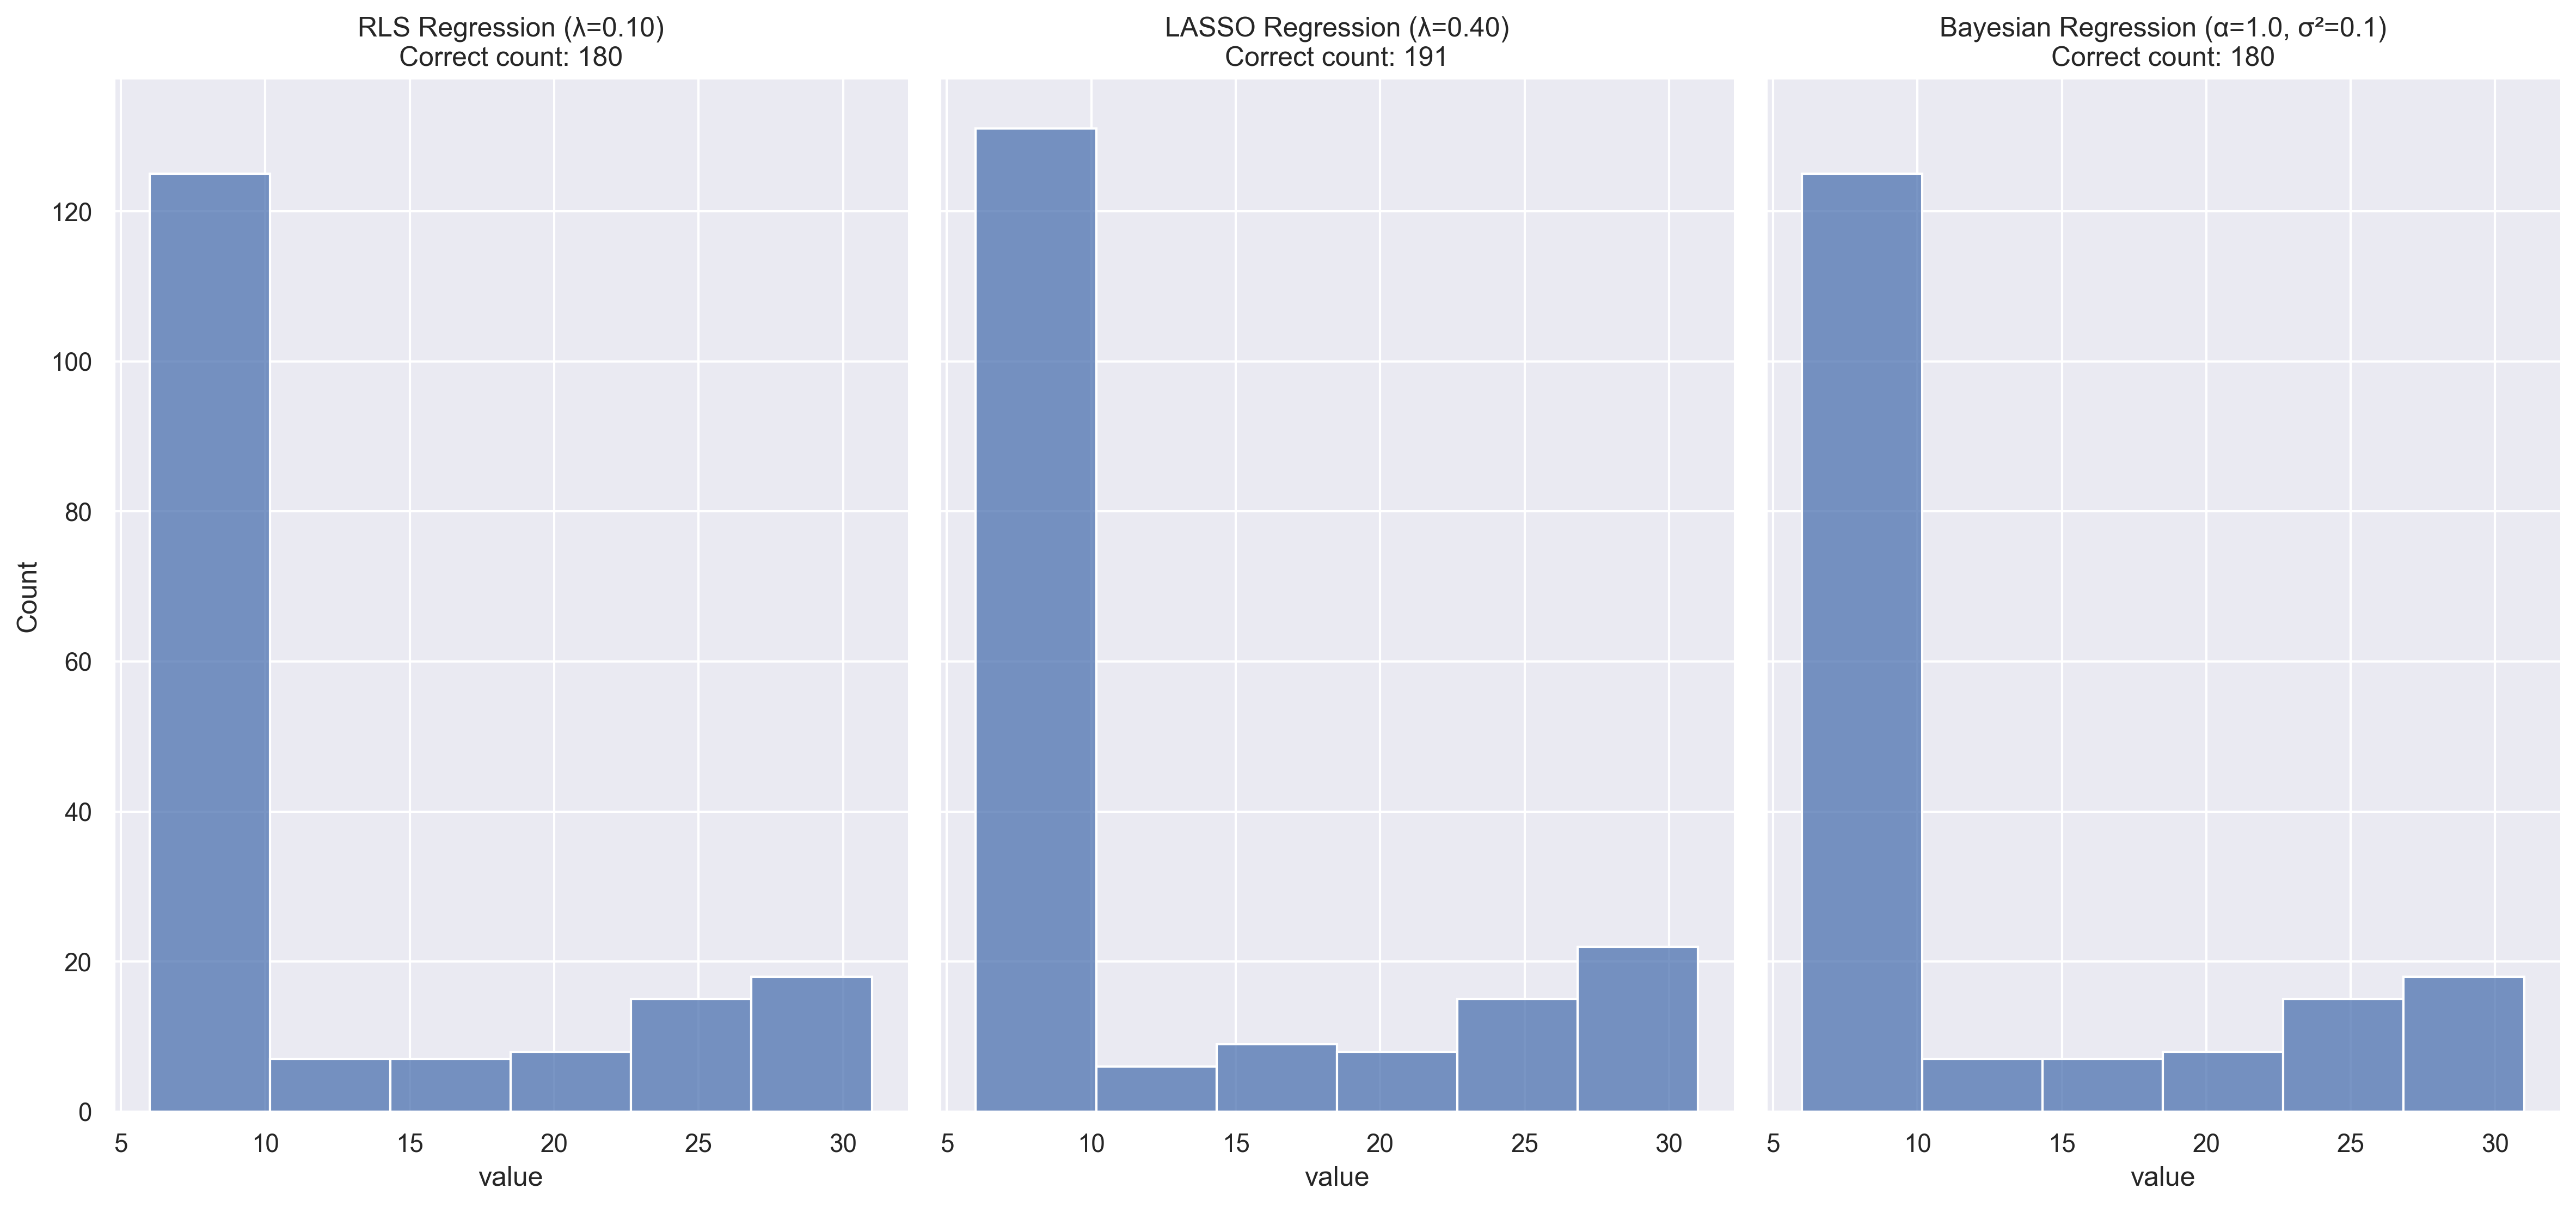

In [28]:
models_3 = [best_rls, best_lasso, best_bayes]
fit_predict_plot_2a(models_3, phi=phi)